### INSTRUCTIONS ON RUNNING THIS NOTEBOOK
- It requires nltk and tries to download it using !pip install command
- It by default it is using a large training set so the model tuning and feature importance calcluations can be accurate
- It is by default set to NOT , REPEAT NOT, RUN TIME CONSUMING CALCULATIONS.
- As you work throught the notebook, some cells will ask you to manually set OK_TO_RUN_TUNING or OK_TO_RUN_FEAT_IMPORT to True.
- Doing so will trigger the lengthy calcuations - up to an hour
- I have included images of the key charts in the README.MD file and in this notebook if you want to see the results without running the full notebook
- With the default OK_TO_RUN_TUNING or OK_TO_RUN_FEAT_IMPORT set to False, the notebook runs in about 20 seconds 

In [1]:
# KEY CONFIGURATION VALUES
# Change this to fun for specific states (less run time)
# Example for Texas: STATE_FILTER = ['tx']
# Example for all: STATE_FILTER = []
STATE_FILTER = ['tx']

BEST_ALPHA = 1 # DEFAULT ALPHA FOR RIDGE() but value can be changed if tuning is run

# Set this False to skip tuning, especially if you don't have a state filter. It may take 30 minutes to run.
OK_TO_RUN_TUNING = True

# Set this to Flase to skip basic feature importance calcuation, especially if you don't have a state filter. It may take 30 minutes to run.
OK_TO_RUN_FEAT_IMPORT = False

# Set this to False to skip more advanced intensive feature importance calcuations, especially if you don't have a state filter. It may take 60 minutes to run.
OK_TO_RUN_FEAT_IMPORT_ADDITIONAL = False





### What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

#### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

#### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Background**: Used car sales dealerships want to fine tune their inventory to improve profits. Their strategy is to identify what factors make a car more or less expensive. Implicit in this strategy is understanding profit margin and return on investment, not just selling more and higher priced vehicles. However, the focus of this study is on understanding what features in a car customers value. We make the assumption that customers express this 'value' by paying a higher price for cars with more valuable features versus those with less valuable features.

**Data Problem Definition:**

*Business Objective*:
- Identify the car features in the data that have the strongest positive correlation with selling price. 
- The ability to identify these corelations should be part of a bigger discussion with stakeholders about the wider business project goals. Assuming ROI of investment in inventory is the ultimate goal, clarify that  developing a causal-based model and subsequently factoring in profit margins of car features would be important 2nd and 3rd stages of  the project.
- This correlation study, along with future causal and profit-margin analysis projects can enable dealers to optimize the ROI of their businesses by more systematically choosing their inventory of cars to sell.

*Data Analytics Objective*: Develop a model and process to ingest used car data, analyze it and rank the most significant features of a car and the least significant features of a car. These rankings will be made based on how they impact the price at which the car sells. Use the most significant features to predict the price that customers would pay for a given set of features.

*Data Sources*:
Kaggle data set of information about 426K used cars

*Key Performance Indicators (KPIs)*:
% of rows of data with valid data in most feature columns: If too much data is missing or invalid, then steps to address this issue must be taken prior to successfully completing the project

Feature Importance: Relative feature importance using the coefficients of a linear regression model tuned and regularized for this context

Change in Error by Feature: Differences in mean squared error for several linear regression models using different subsets of features

Error for Optimized Model: Mean squared error of the best performing linear regression model

Overfitting Check: Difference in training error vs validation error across multiple hyper parameters

**Success Criteria**:

- The ranking process identifies the top 5 MOST signifcant features correlated to sale price of a car based on above KPIs

- The optimized model has a test data MSE less than 10% of the average price of the cars in inventory

**Our result at this stage will be a correlation study. An additional success criteria for this stage is that the analysis guides the efficient design of a randomized control experiments to determine causal impact of features on sale price.**

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Steps to take to gain understanding:**
- Evaluate total number of rows and also number of rows per various categorical groupings.
- Is there a massive amount of data to be managed such that simple queries, regressions and etc will be time-consuming and expensive? 
- Examine the schema (structure and type) of the data. Identify the sales price numerical field(s).
- Are any fields compound or nested data that needs to be further processed (de-normalized, flattended) to be understood?
- Is the data spread out across many data sources such as a relational datamodel with foreign keys?
- Does the data need to be concatenated over multiple similar data sources?
- Visually review the data distribution and range of values of the data. Look for obvious patterns using histograms and box plots. 
- Compare subsets of the data by feature columns grouping to look for relationships like correlation.
- Note if there are major imbalances in the category groupings of the data.
- Look for nulls, suspicious duplicates, outliers, and invalid values.
- Look for data mistakes/inconsistencies in which two domain values are different on different rows, but likely meant to be the same value. Example: 'Blue' and 'blue'.
- Look at mode, frequency and averages of the total and a variety of subgroups of the data, especially in regards to the fields holding the sale price.
- Identify if the data has a time-series aspects like date of sale. Examine the range and distribution of sales price along these time-series axes.

### Code and observations regarding data structure and size

In [2]:
# All imports needed to run this notebook code
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import GridSearchCV
import math
import re
import string
import itertools
import time
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
#!pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import pickle
#!pip install nltk
import nltk
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config



In [3]:
car_df = pd.read_csv('data/vehicles.csv')

In [4]:
print(f"Car df number of rows: {car_df.shape[0]} and column count: {car_df.shape[1]}")

Car df number of rows: 426880 and column count: 18


In [5]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [6]:
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
#print(f"EXPERIMENT FILTERING TO A SINGLE TYPE")
if len(STATE_FILTER) > 0:
    state_filter = STATE_FILTER
    print(f"Running by State of {state_filter}")
    car_state_df = car_df[car_df['state'].isin(state_filter)]
    car_df = car_state_df   
else:
    print("running as normal")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Running by State of ['tx']
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


**Comments on the structure:**
- The 'id' fields looks to be a unique value per row
- 'price' seems to be the target value and the rest besides ID are features
- The structure of the data source is simple - one file. No need for joins, concatenation or integrations
- There are a reasonable number of rows and columns. Not too many to work with using standard tools.


### Code block to help with visual analysis of distribution

In [7]:
# eval_col_counts() gives a sense of the distribution of different distinct values within each column of the data
# For columns with less distinct values less than max_detail(default=15), a bar chart of the count of number of rows
# with that value of that column is show for each distinct value.
# For columns with more than max_detail distinct values, it shows the top max_detail of them.
# It also creates a column 'Rest of values' and shows the count of the remaining values as one bar
# This approach lets us get a sense of the distribution visually even for categories with many distinct values
# You can sort the bar chart by the highest count or by the column value (e.g., show barchart of 'year' from most recent year)
# To do the latter, set sort_by_col parameter to True

import pandas as pd

def get_value_counts(data, column_name, sort_by_col=False):
  # Use value_counts() to get the counts and reset the index to create a DataFrame
  if sort_by_col:
      return data[column_name].value_counts().reset_index(name='count').sort_values(by=column_name, ascending=False)
  else:
      return data[column_name].value_counts().reset_index(name='count')

def get_all_value_counts(data, col_list):
    # Assuming your data is loaded into a pandas DataFrame named 'df'
    for column_to_count in col_list:
        value_counts_df = get_value_counts(car_df, column_to_count)
        print(value_counts_df)


def eval_col_counts(data, col_list, max_detail = 15, sort_by_col = False):
    for column_to_count in col_list:        
        value_counts_df = get_value_counts(data, column_to_count, sort_by_col)
        unq_count = value_counts_df.shape[0]
        print(f"{column_to_count} has {unq_count} distinct values")
        disp_count = min(max_detail,unq_count)
        print(f"See {disp_count} of them")
        print(value_counts_df.head(disp_count))
        if unq_count < 10:
            plt_title = f'Distribution of {column_to_count}'
            plt_data = value_counts_df.copy()
        else:
            plt_title = f'Distribution of top {max_detail} items of {column_to_count} by count'
            plt_data_slice = value_counts_df.head(max_detail)
            plt_data = plt_data_slice.copy()
            plt_data_sum = sum(plt_data['count'])
            all_data_sum = sum(value_counts_df['count'])
            rest_data_sum = all_data_sum - plt_data_sum
            print(f'Count of the rest of the values not shown: {rest_data_sum}')
            # Create a dictionary for the new row
            #new_row = pd.Series({column_to_count: 'Other Columns', 'count': rest_data_sum}, index=df.columns)
            plt_data.loc[len(plt_data)] = [f'Other {unq_count-max_detail} Columns', rest_data_sum]
  
        plt.figure(figsize=(4, 3))  # Adjust figure size as needed 
        sns.barplot(x=column_to_count, y="count", data=plt_data)
        plt.xlabel(column_to_count)
        plt.ylabel('Count')
        plt.title(plt_title)
        plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability
        plt.tight_layout()  # Adjust spacing between elements
        plt.show()

        print("----")




### Distribution of data charts

year has 93 distinct values
See 15 of them
      year  count
0   2018.0   2310
1   2017.0   2214
2   2015.0   1995
3   2016.0   1917
4   2014.0   1801
5   2019.0   1747
6   2013.0   1697
7   2012.0   1190
8   2020.0   1114
9   2011.0    850
10  2008.0    715
11  2007.0    684
12  2010.0    635
13  2009.0    540
14  2006.0    520
Count of the rest of the values not shown: 2968


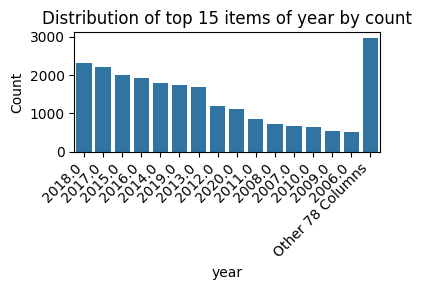

----
fuel has 5 distinct values
See 5 of them
       fuel  count
2     other   2184
3    hybrid    232
0       gas  18073
4  electric     75
1    diesel   2257


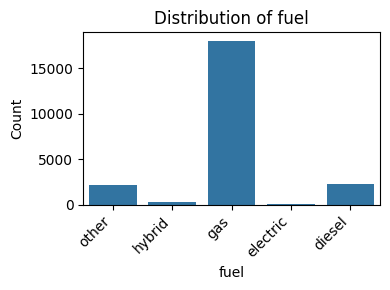

----
type has 13 distinct values
See 13 of them
           type  count
8         wagon    363
7           van    392
3         truck   1482
1         sedan   3885
2        pickup   3293
4         other   1233
11      offroad     54
10     mini-van    188
6     hatchback    790
5         coupe   1102
9   convertible    301
12          bus     21
0           SUV   3894
Count of the rest of the values not shown: 0


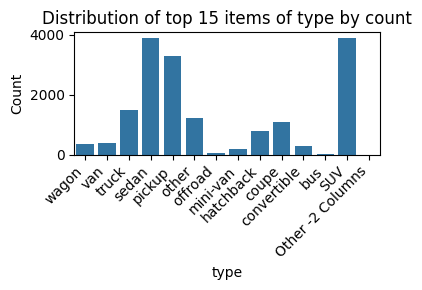

----
manufacturer has 39 distinct values
See 15 of them
     manufacturer  count
25          volvo    146
12     volkswagen    454
2          toyota   1671
33          tesla     39
21         subaru    259
35         saturn     27
26          rover    123
3             ram   1362
30        porsche     80
29        pontiac     81
4          nissan   1146
24     mitsubishi    221
27           mini    108
34        mercury     37
10  mercedes-benz    589
Count of the rest of the values not shown: 15583


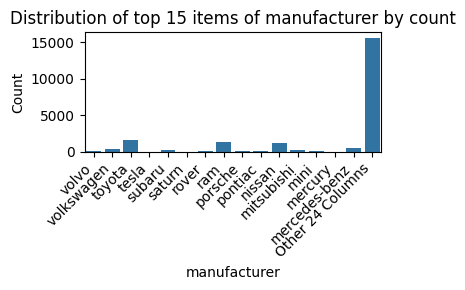

----
state has 1 distinct values
See 1 of them
  state  count
0    tx  22945


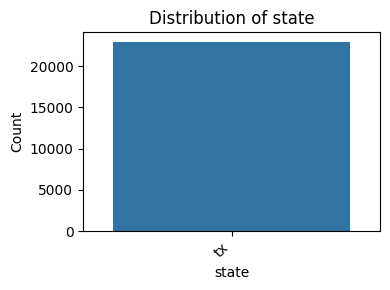

----
size has 4 distinct values
See 4 of them
          size  count
3  sub-compact    232
1     mid-size   2016
0    full-size   3855
2      compact   1161


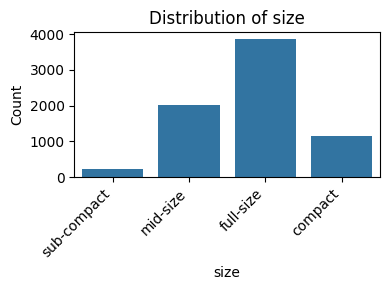

----


In [8]:
# Grader: I have run with all columns but for submission only listing interesting columns. Change col_list to see more
#col_list = ['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders','fuel', 
#            'odometer','title_status', 'transmission','drive','size','type','paint_color','state']
freq_sort_col_list = [ 'manufacturer', 'model', 'condition', 'cylinders','fuel', 
            'odometer','title_status', 'transmission','drive','size','type','paint_color','state']
max_detail = 15
freq_sort_col_list = ['year']
eval_col_counts(car_df, freq_sort_col_list, max_detail = max_detail, sort_by_col = False)

col_sort_col_list = ['fuel','type','manufacturer', 'state', 'size']
eval_col_counts(car_df, col_sort_col_list, max_detail = max_detail,  sort_by_col = True)

### Code block to show relationship of price to each feature column

In [9]:
# support functions for eval_col_avg_price()

def get_average_car_price(data, col):
    average_price_per_category = data.groupby(col)['price'].mean().reset_index()
    return average_price_per_category.sort_values(by=['price','count'], ascending=False)


def get_average_and_count_car_price(data, col):
    average_price_per_category = data.groupby(col).agg(price=('price', 'mean'), count=('price', 'count')).reset_index()
    return average_price_per_category.sort_values(by='price', ascending=False)


def filter_by_price_quantile(data, lower_price_q, upper_price_q):
    price_quantiles = data['price'].quantile([lower_price_q, upper_price_q])
    price_lower_bound = price_quantiles[lower_price_q]
    price_upper_bound = price_quantiles[upper_price_q]

    # Filter DataFrame
    filtered_df = data[(data['price'] >= price_lower_bound) & (data['price'] <= price_upper_bound)]
    
    return filtered_df


def filter_by_price_and_count_quantile(data, lower_price_q, upper_price_q, lower_count_q, upper_count_q):
    price_quantiles = data['price'].quantile([lower_price_q, upper_price_q])
    price_lower_bound = price_quantiles[lower_price_q]
    price_upper_bound = price_quantiles[upper_price_q]

    # Calculate quantiles for count
    count_quantiles = data['count'].quantile([lower_count_q, upper_count_q])
    count_lower_bound = count_quantiles[lower_count_q]
    count_upper_bound = count_quantiles[upper_count_q]

    # Filter DataFrame
    filtered_df = data[(data['price'] >= price_lower_bound) & (data['price'] <= price_upper_bound) &
                 (data['count'] >= count_lower_bound) & (data['count'] <= count_upper_bound)]
    
    return filtered_df

def drop_outlier(data, target_col, IQR_mult):
    # Calculate Interquartile Range (IQR) for price
    Q1 = data[target_col].quantile(0.25)
    Q3 = data[target_col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier threshold (1.5 times IQR)
    threshold = IQR_mult * IQR

    # Identify outliers (outside lower and upper bounds)
    lower_bound = Q1 - threshold
    upper_bound = Q3 + threshold
    outliers = data[(data[target_col] < lower_bound) | (data[target_col] > upper_bound)]
    print(f"drop_outlier(): lower bound = {lower_bound}")
    print(f"drop_outlier(): upper bound = {upper_bound}")    
    # Drop outliers (consider alternative approaches if needed)
    return data.drop(outliers.index)

def handle_extreme_min_max(data_slice, column_to_get_avg, categories, subtitle, size_mult =4 , prefix = None):
        sample_avg = data_slice['price'].mean()

        # min
        min_value_index = data_slice["price"].idxmin() 
        category_w_min_value = data_slice.loc[min_value_index][column_to_get_avg]
        min_value = data_slice.loc[min_value_index]["price"]
        # max
        max_value_index = data_slice["price"].idxmax() 
        category_w_max_value = data_slice.loc[max_value_index][column_to_get_avg]
        max_value = data_slice.loc[max_value_index]["price"]
    
        show_min = min_value > size_mult*sample_avg
        show_max =  max_value < size_mult*sample_avg
            
        if not show_min:
            if len(subtitle)>0:
                subtitle = subtitle + '\n'
            if prefix is None:                
                subtitle = f"{subtitle} MIN is not shown: {category_w_min_value} = {min_value:,.3f} "                
            else:
               subtitle = f"{subtitle} {prefix} not shown: {category_w_min_value} = {min_value:,.3f} "                
                
        if not show_max:
            if len(subtitle)>0:
                subtitle = subtitle + '\n'
            if prefix is None:
                subtitle = f"{subtitle} MAX is not shown: {category_w_max_value} = {max_value:,.3f}"
            else:
                subtitle = f"{subtitle} {prefix} is not shown: {category_w_min_value} = {min_value:,.3f} "                

            
        plt_categories = []
        for category in categories:
            ok_to_add = True
            if category == category_w_min_value:
                ok_to_add =  show_min
            if category == category_w_max_value:
                ok_to_add = show_max
            if ok_to_add:
                plt_categories.append(category)
                    
        return plt_categories, subtitle

def show_min_max_calc(full_avg_data, sample_data_slice, column_to_get_avg, categories, subtitle, size_mult =4 ):
    
        # min
        min_value_index = full_avg_data["price"].idxmin() 
        category_w_min_value = full_avg_data.loc[min_value_index][column_to_get_avg]
        min_value = full_avg_data.loc[min_value_index]["price"]
        min_row = full_avg_data.loc[min_value_index]
        # max
        max_value_index = full_avg_data["price"].idxmax() 
        category_w_max_value = full_avg_data.loc[max_value_index][column_to_get_avg]
        max_value = full_avg_data.loc[max_value_index]["price"]
        max_row = full_avg_data.loc[max_value_index]


        sample_plus_min_max = sample_data_slice.copy()
        sample_plus_min_max.loc[len(sample_plus_min_max)] = min_row
        sample_plus_min_max.loc[len(sample_plus_min_max)] = max_row

        sample_avg = sample_plus_min_max['price'].mean()


        show_min = min_value > size_mult*sample_avg
        show_max =  max_value < size_mult*sample_avg
    
        plt_categories = []
        if not show_min:
            if len(subtitle)>0:
                subtitle = subtitle + '\n'
            subtitle = f"{subtitle} MIN is not shown: {category_w_min_value} = {min_value:,.3f} "                
        else:
            plt_categories.append(category_w_min_value)
            
        if not show_max:
            if len(subtitle)>0:
                subtitle = subtitle + '\n'
            subtitle = f"{subtitle} MAX is not shown: {category_w_max_value} = {max_value:,.3f}"
        else:
            plt_categories.append(category_w_max_value)
               
        for category in categories:
            ok_to_add = True
            if category == category_w_min_value:
                ok_to_add =  show_min
            if category == category_w_max_value:
                ok_to_add = show_max
            if ok_to_add:
                plt_categories.append(category)            
                
        return plt_categories, subtitle

def handle_many_distinct_averages(data, column_to_get_avg, value_avg_df, subtitle):
            
        plt_title = f'Average price and spread of min avg, max avg and sample of {max_detail-2} items of {column_to_get_avg}'
        
        # too many categoires to show on a chart so get a sample of max_detail of them to show on boxplot
        # sample 2 more than I need so I can drop ones that might put out of scale
        sample_data_slice = value_avg_df.sample(max_detail).sort_values(by='price')
        initial_len = sample_data_slice.shape[0]
        sample_data_slice = sample_data_slice[1:initial_len-1]
        sample_categories = sample_data_slice[column_to_get_avg]

        # add overall min and max but handlife if it so vastly different than sample that will ruin chart
        plt_categories, subtitle = show_min_max_calc(value_avg_df, sample_data_slice, column_to_get_avg, sample_categories, subtitle)
 
        plt_data = data[data[column_to_get_avg].isin(plt_categories)]

        return plt_data, plt_title, subtitle


In [10]:
# eval_col_avg_price() routine helps get a sense of the rawnge of values for each column.
# For columns with less than max_detail(default=15) distinct values, it shows each column
# For columns with more, it shows the min, max and a sample of 13 values.
# Specifically, it finds the average for each distinct column into a separate dataframe, then finds the min and max average
# then it samples (max_detail - 2) columnns from that set of averages
# finally it shows the box plot for the min, the samples, and the max average.
# By default it does not include outliers in the chart but passing a parameter can show them.
# Note 1: outliers can scale the chart such that it hard to read for other boxplots.
# Note 2: For the column values corresponding to the min/max average are less/more than 4 times smaller/bigger,
# the boxplot for it is not shown but the average is shown in a subtitle of the plot. 
# This solution reduces the chance of big mis matches in scale for boxplots shown. However,
# If the sampling of averages hits a particularly high or low value, the chart will be skewed.

def draw_box_plot(plt_data_orig, column_to_get_avg, showfliers_flag,  subtitle, plt_title):

    plt_data = plt_data_orig.copy()
    plt_data[column_to_get_avg] = plt_data[column_to_get_avg].astype(str).str[:30].replace('$', ' ', regex=False)
    plt.figure(figsize=(8, 5))  # Adjust figure size as needed 
    sns.boxplot(
        x = column_to_get_avg,
        y = "price",
        showmeans=True,  # Add means (optional)
        showfliers = showfliers_flag,
        data=plt_data)

    plt.xlabel(column_to_get_avg)
    plt.ylabel('Average Price')
    plt.title(subtitle)
    plt.suptitle(plt_title)
    plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability
    plt.tight_layout()  # Adjust spacing between elements

    plt.show()

    plt.cla()
    plt.clf()

def draw_price_and_count_plot(plt_data_orig, column_to_get_avg, title, subtitle, max_detail):

    # next check if need to downsample
    print("Processing Avg Price and Count Chart - May take up to 30 seconds for some charts")
    skip_data_msg = ""
    orig_row_count = plt_data_orig.shape[0]
    if orig_row_count > 2000:
        skip_amount = plt_data_orig.shape[0] // 2000
        plt_data = plt_data_orig.iloc[::skip_amount] 
        row_count_w_skip = plt_data.shape[0]
        skip_data_msg = f"\nLarge # of values({orig_row_count:,.0f}), charting every 2000th item"
    else:
        plt_data = plt_data_orig
    duplicates = plt_data[column_to_get_avg].duplicated()
    has_duplicates = plt_data[column_to_get_avg].duplicated().any()
    if has_duplicates:
        print("has duplicates")
    else:
        print("no duplicates")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(5, 3))

    #Line plot for value1 (left y-axis)
    if plt_data.shape[0] <max_detail:
            ax1.plot(
                plt_data[column_to_get_avg].astype(str).str[:30].replace('$', ' ', regex=False), 
                plt_data["price"], label='Average Price', marker= 'o')
    else:
        if len(skip_data_msg)>0:
             ax1.plot(
                plt_data[column_to_get_avg], 
                #plt_data[column_to_get_avg],
                plt_data["price"], label='Average Price')
        else:
                ax1.plot(
                plt_data[column_to_get_avg].astype(str).str[:30].replace('$', ' ', regex=False), 
                #plt_data[column_to_get_avg],
                plt_data["price"], label='Average Price')

    ax1.set_ylabel('Average Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    
    if plt_data.shape[0] <= max_detail:
        ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    else:
        plt.xticks([])  
        
    # Bar chart for value2 (right y-axis)
    ax2 = ax1.twinx()  # Create a twin axes for value2
    ax2.bar(plt_data[column_to_get_avg].astype(str).str[:30].replace('$', ' ', regex=False), plt_data["count"], color='g', alpha=0.7, label='Count')
    ax2.set_ylabel('Count', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Customize the plot
    plt.title(f"{subtitle}" + skip_data_msg )
    plt.suptitle(title)
    plt.xlabel(column_to_get_avg)


    if plt_data.shape[0] <= max_detail:
        ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    else:
        plt.xticks([])  
        
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
    plt.tight_layout()
    
    # show
    plt.show()

    # release shared mem related to plotting
    plt.cla()
    plt.clf()

def set_base_box_subtitle(showfliers_flag, 
                        lower_price_q, upper_price_q, lower_count_q, upper_count_q):
    
    if lower_price_q == 0 and upper_price_q ==1 and lower_count_q == 0 and upper_count_q==1:
        box_subtitle = "Row criteria: ALL"
    else:
        box_subtitle = f"Price criteria: start % = {lower_price_q:.2%}, end % = {upper_price_q:.2%}"
        box_subtitle = box_subtitle + f"\nCount criteria: start % = {lower_count_q:.2%}, end % = {upper_count_q:.2%}"
    if showfliers_flag:
        box_subtitle = box_subtitle + "\nOutliers (1.5 times the IQR) shown"
    else:
        box_subtitle = box_subtitle + "\nOutliers (1.5 times the IQR) not shown on chart"
    return box_subtitle

def get_quantile(data, column_name, value, data_max, data_quantiles):
  
  if value < data_quantiles[0.25]:
    return 'Zero to 25th quantile'
  elif value < data_quantiles[0.5]:
    return 'Above 25th to 50th quantile'
  elif value < data_quantiles[0.75]:
    return 'Above 50th to 75th quantile'
  else:
    return 'Above 75th to 100th quantile'

def eval_col_avg_price(data, col_list, max_detail = 15, showfliers_flag = False, 
                        lower_price_q = 0, upper_price_q = 1, lower_count_q = 0, upper_count_q =1):
    for column_to_get_avg in col_list:
        base_box_subtitle = set_base_box_subtitle(showfliers_flag, 
                        lower_price_q, upper_price_q, lower_count_q, upper_count_q)
        # aggregate primary data to get avg price and count

        value_avg_df_orig = get_average_and_count_car_price(data, column_to_get_avg)

        # apply percentile criteria to value averages. 
        # goal is to filter by quantiles so to reduce the number of categories included in the box plot.
        # goal is NOT to limit/filter the core price data set by quantile for the categories we want
        value_avg_df = filter_by_price_and_count_quantile(value_avg_df_orig, 
                        lower_price_q, upper_price_q, lower_count_q, upper_count_q)
        # Saving to database to manually reivew for bad data set in excel
        #value_avg_df.to_csv(f'saved_output/{column_to_get_avg}_avg_prices.csv')

        # share some basic info about the column
        unq_count = value_avg_df.shape[0]
        print(f"{column_to_get_avg} has {unq_count} distinct values")
        disp_count = min(max_detail,unq_count)
        print(f"See {disp_count} of them")
        top_of_value_avg_df = value_avg_df.head(disp_count)
        top_of_value_avg_df = top_of_value_avg_df.copy()
        top_of_value_avg_df['price'] = top_of_value_avg_df['price'].apply(lambda x: '${:,.0f}'.format(x))        
        print(top_of_value_avg_df)
        
        # prepare to plot the box plot
        if disp_count != 0:
            if unq_count < max_detail:            
                box_plt_title = f'Average price and spread of {column_to_get_avg}'
                categories = value_avg_df[column_to_get_avg]
                plt_categories, box_subtitle = handle_extreme_min_max(value_avg_df, column_to_get_avg, categories, base_box_subtitle, 4)
                print("Will display all categories:")
                print(plt_categories)
                plt_data = data[data[column_to_get_avg].isin(plt_categories)]                
            else:
                plt_data, box_plt_title, box_subtitle = handle_many_distinct_averages(data, column_to_get_avg, value_avg_df, 
                                                                                      base_box_subtitle)                

            # draw boxplot of price for category 
            draw_box_plot(plt_data, column_to_get_avg, showfliers_flag,  box_subtitle, box_plt_title)
        
            # prepare to plot both average price and count per category value on same chart
            # first get a version without outlier averages
            IQR_mult = 1.5
            data_no_outlier = drop_outlier(value_avg_df, "price", IQR_mult)
            print(f"Potential outliers for {column_to_get_avg} = {value_avg_df.shape[0] - data_no_outlier.shape[0]}")
    
            # set title
            multi_title = f"Plot of Avg Price and Count for {column_to_get_avg}"
            multi_subtitle = base_box_subtitle
            draw_price_and_count_plot(data_no_outlier, column_to_get_avg, multi_title, multi_subtitle, max_detail)        
        else:
            print(f"****No values of {column_to_get_avg} are in the given critera so no plots to display****")

        print("----")



### Charts relating price to feature columns

manufacturer has 39 distinct values
See 15 of them
     manufacturer    price  count
10        ferrari  $49,450      2
30        porsche  $36,237     80
35          tesla  $33,722     39
32          rover  $32,976    123
6       chevrolet  $31,616   3133
31            ram  $30,584   1362
18         jaguar  $29,967    107
1      alfa-romeo  $28,474     55
2            audi  $25,442    338
13            gmc  $23,645    897
12           ford  $23,318   4456
5        cadillac  $22,663    349
24  mercedes-benz  $22,224    589
0           acura  $21,228    283
19           jeep  $20,637    931


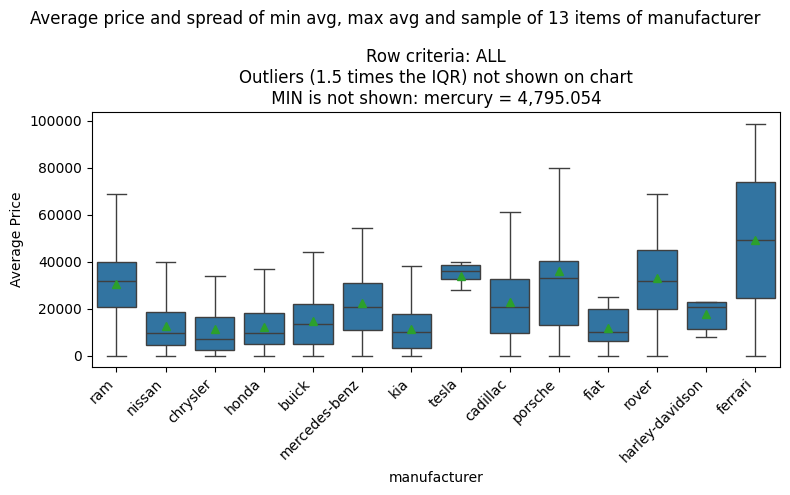

drop_outlier(): lower bound = -2640.920571002518
drop_outlier(): upper bound = 39155.141850016014
Potential outliers for manufacturer = 1
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

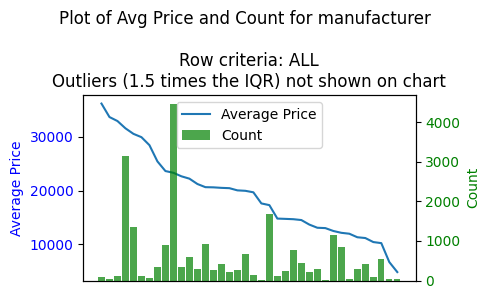

----
condition has 6 distinct values
See 6 of them
   condition    price  count
1       fair  $95,950    274
2       good  $21,007   6351
4        new  $19,074     62
3   like new  $16,841   1890
0  excellent  $14,094   4608
5    salvage   $4,010     32
Will display all categories:
['fair', 'good', 'new', 'like new', 'excellent']


<Figure size 640x480 with 0 Axes>

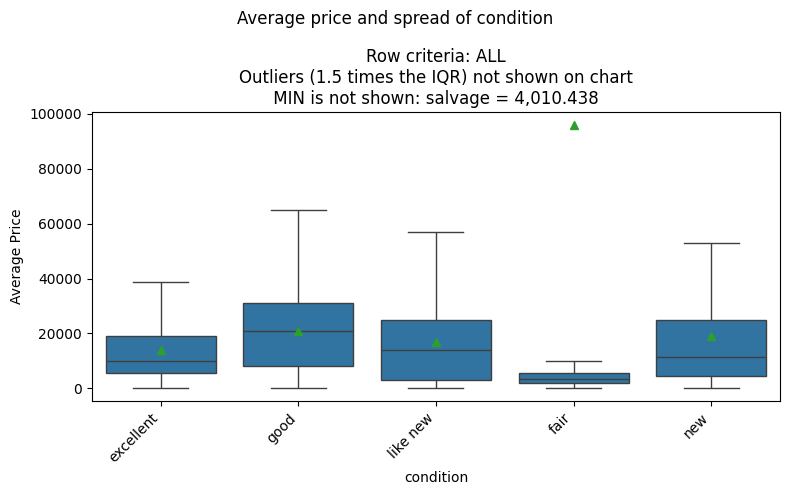

drop_outlier(): lower bound = 6165.663328185683
drop_outlier(): upper bound = 29138.936216141148
Potential outliers for condition = 2
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

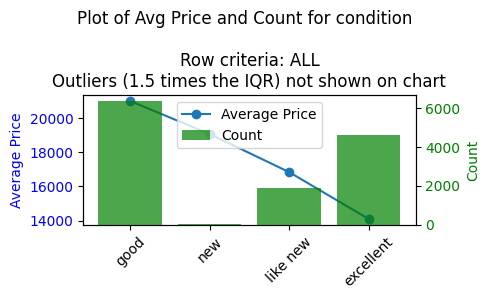

----
fuel has 5 distinct values
See 5 of them
       fuel    price  count
4     other  $34,044   2184
0    diesel  $33,144   2257
1  electric  $22,994     75
2       gas  $18,397  18073
3    hybrid  $17,743    232
Will display all categories:
['other', 'diesel', 'electric', 'gas']


<Figure size 640x480 with 0 Axes>

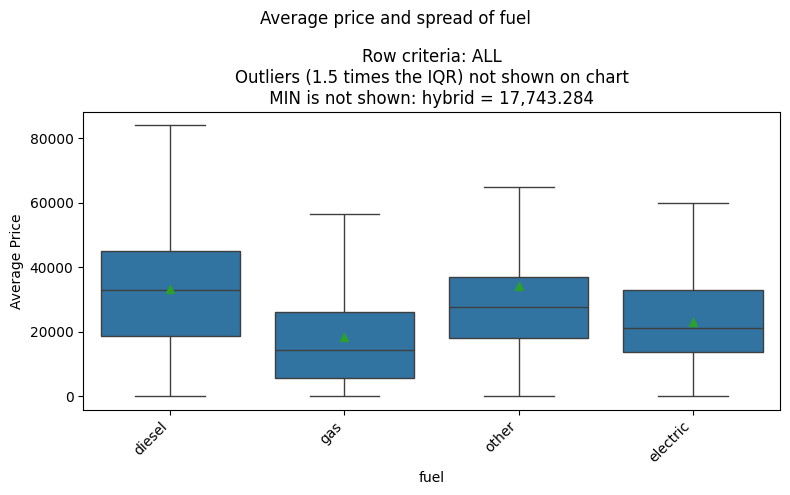

drop_outlier(): lower bound = -3723.5836688852105
drop_outlier(): upper bound = 55264.0575119204
Potential outliers for fuel = 0
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

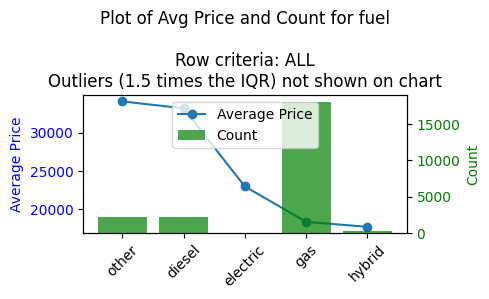

----
state has 1 distinct values
See 1 of them
  state    price  count
0    tx  $21,344  22945
Will display all categories:
['tx']


<Figure size 640x480 with 0 Axes>

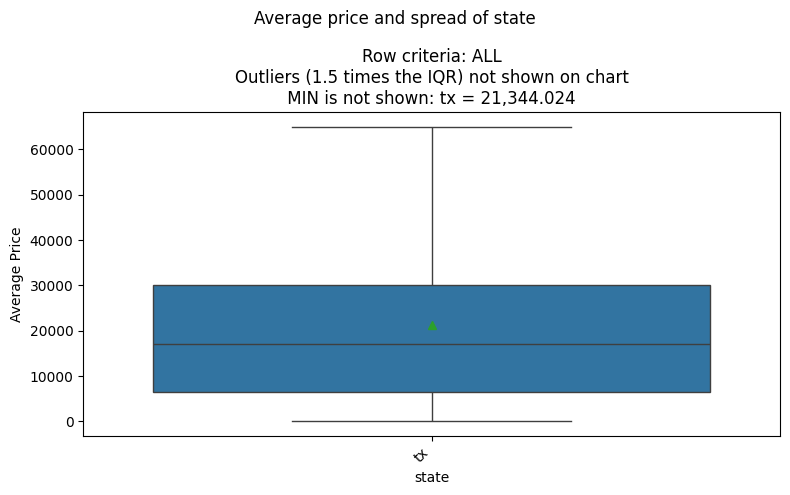

drop_outlier(): lower bound = 21344.024449771194
drop_outlier(): upper bound = 21344.024449771194
Potential outliers for state = 0
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

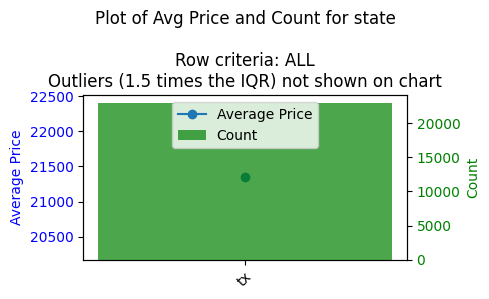

----
year has 93 distinct values
See 15 of them
      year     price  count
61  1991.0  $786,743     32
25  1955.0  $580,973     24
91  2021.0   $39,135    136
6   1930.0   $38,440      5
9   1933.0   $38,000      1
11  1936.0   $36,250      2
14  1940.0   $35,700      1
22  1952.0   $35,000      3
90  2020.0   $34,256   1114
89  2019.0   $32,856   1747
8   1932.0   $29,500      1
88  2018.0   $27,103   2310
87  2017.0   $26,544   2214
32  1962.0   $26,218     11
13  1939.0   $26,167      3


<Figure size 640x480 with 0 Axes>

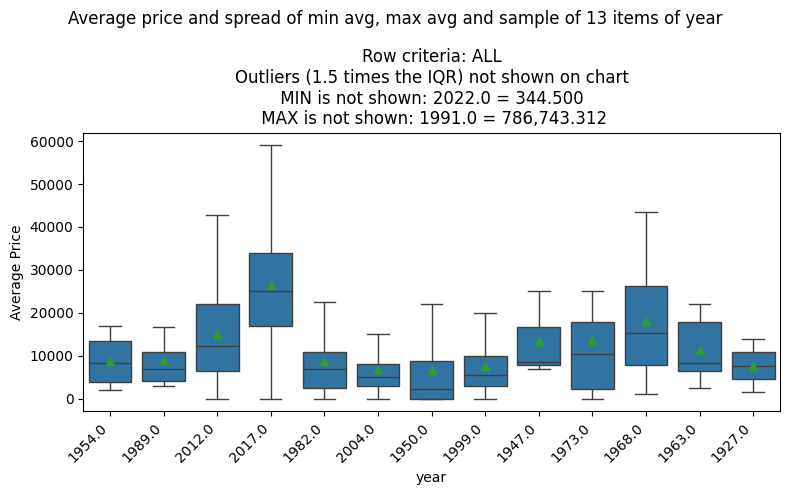

drop_outlier(): lower bound = -7508.028822055139
drop_outlier(): upper bound = 35789.06390977444
Potential outliers for year = 6
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

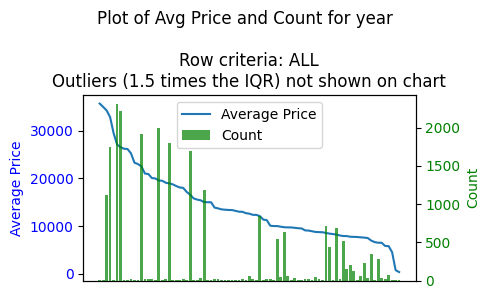

----


<Figure size 640x480 with 0 Axes>

In [11]:
col_list = ['manufacturer','condition','fuel', 
            'state','year']

eval_col_avg_price(car_df, col_list, 
                    lower_price_q = 0.0, upper_price_q = 1, lower_count_q = 0.0, upper_count_q =1)

### Observations from chart analysis
#### Task: Visually review the data distribution and range of values of the data. Look for obvious patterns using histograms and box plots.
The following features look to have interesting combination of high volume of sales and at a high price:
- feature: cylinders, value = 6
- feature: title_status, value = lien
- feature: drive, value = 4wd
- feature: type, value = SUV
- feature: paint_color, values: (Black, White)
- feature: manufacturer, value: will drill down but one manufacturer has a relatively high avg price and very high volume
  
NOTE: There are other more obvious relationship of high volume and price combinations not mentioned (like condition:excellent)

- There are many price-volume variations for features state, manufacturer, model and year. However, there are so many distinct values of each of these features that it is hard to visualize pattern.
- So I have built into the visualizations a way to slice the data by quantiles of price and sales volume(count) and look at those charts. Will do so after clean-up.
  
#### Task: Note if there are major imbalances in the category groupings of the data.
The most non-obvious category data imbalances are:
- condition: fair has very low volume compared to good and excellent. I expected 'fair' to be lower but it is several times lower volume
- paint_color: Both black and white are significantly more popular than other colors.

*NOTE: Will redo these charts after the outlier and null data clean-up*


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Remove VIN feature
- VIN is a unique number per vehicle (per row)
- We will drop this row from our modeling analysis because it will not have general predictive power

#### Data with nulls

In [12]:
print(f"Before Clean-up: Total cells in dataframe with NULLs = { car_df.isnull().sum().sum() }")

Before Clean-up: Total cells in dataframe with NULLs = 70324


In [13]:
print(f"Before Clean-up: Total rows with one or more NULLs  = {car_df.isnull().any(axis=1).sum()}")



Before Clean-up: Total rows with one or more NULLs  = 21535


#### Code to identify trade off of null data and number of features

In [14]:


def nan_count_in_a_col(data, col):
    return data[col].isnull().sum()

def nan_count_by_col(data):
    nans_df = pd.DataFrame(columns=['src_col', 'nan_count'])
    for col in data.columns:
        nan_count = nan_count_in_a_col(data, col)
        new_row = {'src_col': col, 'nan_count':nan_count}
        nans_df.loc[len(nans_df)] = new_row
    nans_df = nans_df.sort_values(by='nan_count', ascending = False)
    
    return nans_df
    

In [15]:
def find_feat_to_max_non_null_rows(car_df, start_count, end_count, 
                                                  col_list = ['region', 'manufacturer', 'model', 'condition', 'cylinders','fuel', \
                                                  'title_status', 'transmission','drive','size','type','paint_color','state', 'odometer','year'], 
                                                  use_previous_run = True):
    # Uses itertools.combinations() to search for the best combinations of features to maximize the number of *non-null* rows 
    # It finds combinations of length start_count to end_count
    # Returns two lists: max_non_null_count, max_non_null_combo
    # NOTE: The run time for this function is over an hour when used with start_count=0, end_count=15
    # Therefore, I have a hard-coded list for that size and a flag to use that cached version, use_previous_run=True
    if use_previous_run == True:
        final_list_counts_from_previous_run = [426880, 426880, 425675, 423187, 421081, 417551, 412372, 405594, 389604, 306976, 252977, 205777, 156527, 115988, 79195]
        final_list_features_from_previous_run = [['region'], ['region', 'state'], ['region', 'state', 'year'], ['region', 'transmission', 'state', 'year'], \
                                                 ['region', 'fuel', 'transmission', 'state', 'year'], ['region', 'fuel', 'transmission', 'state', 'odometer', 'year'],\
                                                 ['region', 'model', 'fuel', 'transmission', 'state', 'odometer', 'year'], ['region', 'model', 'fuel', 'title_status', \
                                                                                                                            'transmission', 'state', 'odometer', 'year'], \
                                                 ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state', 'odometer', 'year'], \
                                                 ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'type', 'state', 'odometer', 'year'],\
                                                 ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state', 'odometer', 'year'],\
                                                 ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'odometer', 'year'], \
                                                 ['region', 'manufacturer', 'model', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', \
                                                  'paint_color', 'state', 'odometer', 'year'], ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',\
                                                                                                'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'odometer', 'year'], \
                                                 ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', \
                                                  'type', 'paint_color', 'state', 'odometer', 'year']]
        return final_list_counts_from_previous_run,final_list_features_from_previous_run
    else:
        # longer run-time branch so use print() statements to keep user informed
        cur_non_null_row_count = []
        max_non_null_count = []
        max_non_null_combo  = []
        col_list = ['region', 'manufacturer', 'model', 'condition', 'cylinders','fuel', 
                    'title_status', 'transmission','drive','size','type','paint_color','state', 'odometer','year'] 
        total_rows = car_df.shape[0]
        start_count = 0
        end_count = 15
        cur_non_null_row_count = [None]*(end_count)
        max_non_null_count = [None]*(end_count)
        max_non_null_combo = [None]*(end_count)
        for col_len in range(start_count,end_count):
                print("new outer loop")
                print(col_len)        
                #cur_non_null_row_count.append(None)
                #max_non_null_count.append(None)        
                #max_non_null_combo.append(None)
                combinations = list(itertools.combinations(col_list, col_len+1))    
                print(f"Combos to process: {len(combinations)}")
                start_time = time.time()
                for combo in combinations:    
                    combo_list = list(combo)
                    #print(f"new combo: {combo_list}")
                    cur_count_of_rows_wth_nulls = car_df[car_df[combo_list].isnull().any(axis=1)].shape[0]            
                    cur_non_null_row_count[col_len] = total_rows - cur_count_of_rows_wth_nulls
                    if max_non_null_count[col_len] is None or cur_non_null_row_count[col_len] > max_non_null_count[col_len]:
                        max_non_null_count[col_len] = cur_non_null_row_count[col_len]
                        max_non_null_combo[col_len] = combo_list
                end_time = time.time()
                elapsed_time = end_time - start_time
                print("Elapsed time:", elapsed_time, "seconds")
                print("---")
    
        print(max_non_null_count)            
        print(max_non_null_combo)
        return max_non_null_count, max_non_null_combo
            
#rows_with_nulls = car_df[combo][car_df[combo].isnull().any(axis=1)].reset_index()
#rows_with_nulls.rename(columns={'index': 'src_index'}, inplace=True)


In [16]:
max_non_null_count, max_non_null_combo = find_feat_to_max_non_null_rows(car_df,0,15)

In [17]:
def chart_features_vs_non_null_rows(max_non_null_count, max_non_null_combo):
    final_list = zip(max_non_null_count, max_non_null_combo)
    feature_choices = pd.DataFrame(final_list, columns = ['non_null_row_count', 'features'])
    f_c = feature_choices[feature_choices['features'].notnull()]
    f_c = f_c.copy()
    f_c['p_features'] = f_c['features'].shift(periods=1,fill_value = ['no features'])
    f_c['feature_change'] = f_c.apply(lambda row: list(set(row['features']) - set(row['p_features'])), axis=1)
    f_c['feature_change_desc'] = f_c.apply(lambda row: "Add " +  " , ".join(row['feature_change']), axis=1)
    f_c
    sns.barplot(x='feature_change_desc', y='non_null_row_count', data=f_c)
    plt.xlabel('Feature added to previous feature list')
    plt.ylabel('Rows without Nulls for this feature set')
    plt.suptitle('Impact of feature inclusion on non-null row count')
    plt.title('Read left to right. \nEach bar ads a feature to the data set')  
    plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability   
    plt.tight_layout()  # Adjust spacing between elements
    plt.show()
    plt.cla()
    plt.clf()

#### Charts to identify trade off of null data and number of features

In [18]:
print(nan_count_by_col(car_df))

         src_col  nan_count
14          size      15681
12           VIN      11256
7      cylinders      10543
6      condition       9728
13         drive       8398
16   paint_color       6862
15          type       5947
4   manufacturer       1019
5          model        310
9       odometer        194
8           fuel        124
10  title_status        112
11  transmission        102
3           year         48
0             id          0
1         region          0
2          price          0
17         state          0


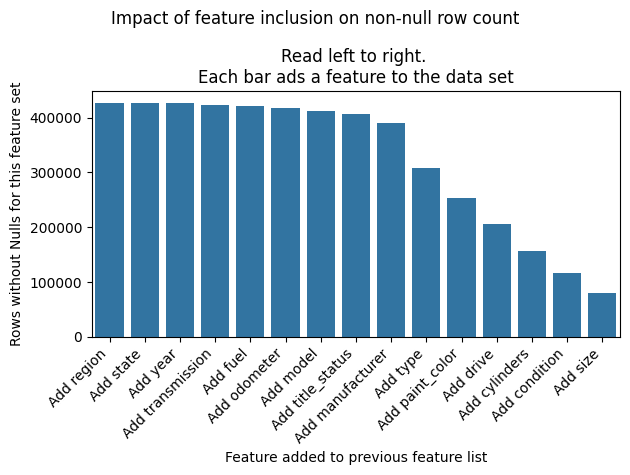

<Figure size 640x480 with 0 Axes>

In [19]:
chart_features_vs_non_null_rows(max_non_null_count, max_non_null_combo)

### Strategy to handle null data

The above chart (Imapct of feature inclusion...) is a useful tool I created to make practical decisions about outliers. If there is value in including all the above features, then our total data set shrinks from over 400K rows to under 100K rows. 
While 100K rows is significant, losing 300K+ rows of information could easily degrade predictive capabilities. This chart helps evaluate the combinations that manage this trade-off. 

We won't know until we run actual modeling how valuable a given feature is. However, looking at the price-volume charts in the previous section we can estimate the potential of **size, condition, cylinders, drive, paint color and type**. 
Each of these columns significantly reduce the number of non-null rows.
- size has good price and volumne variation but the most null values
- drive, fuel, cylinders, and condition do not have strong variation in BOTH price and volume and they significantly reduce rows available for training and testing.
- type and paint color are attractive to keep because they do have strong price and volume variation while reducing the number of available rows less significantly than others.

Thus, our best initial estimates of features to explore further are including up to paint_color in our main data set. Making for a feature list as follows:
- region, state, year, transmission, fuel, odometer, model, title_status, manufacturer, type, paint_color
- This will give us  rows of data 252,977 - a loss of 40% of the rows available
- Note this won't be a good choice if there is significant collinearity of paint_color and type with region, state, year, transmission, fuel, odometer, model, title_status, or manufacturer. This will show up  when we do linear regression. Therefore, we will start with this column list and revisit as needed

*NOTE: Time permitting and as needed, we will also repeat the modeling assuming we have all features (79,195 rows) and also assuming we have only up to manufacturer (drop type and paint color for total of 389,604 rows)*

#### Code to remove outliers

In [20]:
balanced_col = ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state', 'odometer', 'year']
print(f"original dataframe row count = {car_df.shape[0]}")
balanced_col_keep = balanced_col.copy()
balanced_col_keep.append('id')
balanced_col_keep.append('price')
car_df_no_nulls_balanced = car_df[balanced_col_keep][car_df[balanced_col].notnull().all(axis=1)]
print(f"balanced dataframe row count = {car_df_no_nulls_balanced.shape[0]}")
print(car_df_no_nulls_balanced.columns)

# for later try more rows and less features
more_rows_col = ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'state', 'odometer', 'year']
more_rows_col_keep = more_rows_col.copy()
more_rows_col_keep.append('id')
more_rows_col_keep.append('price')

car_df_no_nulls_more_rows = car_df[more_rows_col_keep][car_df[more_rows_col].notnull().all(axis=1)]
print(f"'more rows' dataframe row count = {car_df_no_nulls_more_rows.shape[0]}")

# Try these if time or if above doesn't perform well
# don't use 'size' in any case. probably overlap with type and cylinder and cuts too many rows.
more_feat_col =   ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', \
                                                  'type', 'paint_color', 'state', 'odometer', 'year']
more_feat_col_keep = more_feat_col.copy()
more_feat_col_keep.append('id')
more_feat_col_keep.append('price')

car_df_no_nulls_more_feat = car_df[more_feat_col_keep][car_df[more_feat_col].notnull().all(axis=1)]
print(f"'more features' dataframe row count = {car_df_no_nulls_more_feat.shape[0]}")


original dataframe row count = 22945
balanced dataframe row count = 13856
Index(['region', 'manufacturer', 'model', 'fuel', 'title_status',
       'transmission', 'type', 'paint_color', 'state', 'odometer', 'year',
       'id', 'price'],
      dtype='object')
'more rows' dataframe row count = 21212
'more features' dataframe row count = 5716


In [21]:
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("Choice of null data strategy")
print("I choose 'balanced'")
cars_no_nulls = car_df_no_nulls_balanced
#print("I choose 'more_feat'")
#cars_no_nulls = car_df_no_nulls_more_feat
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print(cars_no_nulls.info())

print("cars_no_nulls row count:")
print(cars_no_nulls.shape[0])

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Choice of null data strategy
I choose 'balanced'
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
<class 'pandas.core.frame.DataFrame'>
Index: 13856 entries, 362637 to 385575
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        13856 non-null  object 
 1   manufacturer  13856 non-null  object 
 2   model         13856 non-null  object 
 3   fuel          13856 non-null  object 
 4   title_status  13856 non-null  object 
 5   transmission  13856 non-null  object 
 6   type          13856 non-null  object 
 7   paint_color   13856 non-null  object 
 8   state         13856 non-null  object 
 9   odometer      13856 non-null  float64
 10  year          13856 non-null  float64
 11  id           

#### Outliers

Typical approach is to look at 1.5 times the IQR
- For this project we will model twice: once using 1.5 X IQR and again using 3.0 X IQR
- Important to understand if there are traunches or clusters of outliers. This could be legitimate data when data gets segregated by a particular feature combination
- For example, Ferraris cost far more than Mercuries. The Ferrari price might seem like an outlier but compared to other luxury manufacturers it will be legitimate data 

For category fields with a manageable range of distinct values we will try to manually review all outliers and decide based on judgment

Lastly, an outlier may be a bad data point or it may be a datapoint with a typo or other recognizable mistake that if corrected would no longer be an outlier. 
- We will try to identify these situations

#### Code to analyze outlier removal process

In [22]:
def plot_outliers_vs_orig(orig, no_nulls, outlier_level1_removed, outlier_level2_removed, samp_size, plots=[1,2,3,4], ids_to_use=None):
  plt.figure(figsize=(5, 3))
  
  # assumption we would never plot 10 million points
  cur_min = 1000000
  if samp_size == 'All' and ids_to_use is None:
      if 1 in plots:
          cur_min = min(orig.shape[0], cur_min)
      if 2 in plots:
          cur_min = min(no_nulls.shape[0], cur_min)
      if 3 in plots:
          cur_min = min(outlier_level1_removed.shape[0], cur_min)
      if 4 in plots:
          cur_min = min(outlier_level2_removed.shape[0], cur_min)
      plt_samp_size = cur_min
  else:
      if ids_to_use is None:
          plt_samp_size = samp_size
      else:
          plt_samp_size = ids_to_use.shape[0]      

  if ids_to_use is None:
      plt_id = orig.sample(plt_samp_size)
  else:
      plt_id = ids_to_use
  
  plt_orig = pd.merge(plt_id["id"], orig, on='id', how='left')
  plt_no_nulls = pd.merge(plt_id["id"], no_nulls, on='id', how='left')
  plt_outlier_level1_removed = pd.merge(plt_id["id"], outlier_level1_removed, on='id', how='left')
  plt_outlier_level2_removed = pd.merge(plt_id["id"], outlier_level2_removed, on='id', how='left')

  plt_orig = plt_orig.sort_values(by="id")
  plt_no_nulls = plt_no_nulls.sort_values(by="id")
  plt_outlier_level1_removed = plt_outlier_level1_removed.sort_values(by="id")
  plt_outlier_level2_removed = plt_outlier_level2_removed.sort_values(by="id")

  # adjust values so less overlap
  adj_range = 0
  plt_orig_a = plt_orig.copy()
  plt_orig_a['price'] = plt_orig_a['price'] + random.randint(-adj_range, adj_range)
  plt_no_nulls_a = plt_no_nulls.copy()
  plt_no_nulls_a['price'] = plt_no_nulls_a['price'] + random.randint(-adj_range, adj_range)
  plt_outlier_level1_removed_a = plt_outlier_level1_removed.copy()
  plt_outlier_level1_removed_a['price'] = plt_outlier_level1_removed_a['price'] + random.randint(-adj_range, adj_range)
  plt_outlier_level2_removed_a = plt_outlier_level2_removed.copy()
  plt_outlier_level2_removed_a['price'] = plt_outlier_level2_removed_a['price'] + random.randint(-adj_range, adj_range)    
    
  # Plot each DataFrame with a different color
  if 1 in plots:
      plt.plot(plt_orig_a['id'], plt_orig_a['price'], label='orig', color='black')
  if 2 in plots:      
      plt.plot(plt_no_nulls_a['id'], plt_no_nulls_a['price'], label='Before outlier removal', color='blue',alpha=0.95)
  if 3 in plots:    
      plt.plot(plt_outlier_level1_removed_a['id'], plt_outlier_level1_removed_a['price'], label='Outlier removal IQR*1.5 (typical)', color='green',alpha=0.9)
  if 4 in plots:    
      plt.plot(plt_outlier_level2_removed_a['id'], plt_outlier_level2_removed_a['price'], label='Outlier removal IQR*3 (keep even more outliers)', color='red',alpha=0.65)
  

  # Add labels and title
  plt.xlabel('ID')
  plt.ylabel('Price')
  plt.title(f'Comparison of Prices \n(Sample Size = {plt_samp_size})') 


  # Add legend
  plt.legend()

  plt.show()    
  return ids_to_use
   

#### Data and charts about outlier removal

In [23]:
# drop price outliers 1.5 and 2.0 IQR
# base assumption of outliers
IQR_mult1=1.5
car_df_no_outliers_1_IQR = drop_outlier(cars_no_nulls, 'price', IQR_mult1)
rows_removed1 = cars_no_nulls.shape[0]  - car_df_no_outliers_1_IQR.shape[0]
rows_removed_pct1 = rows_removed1/cars_no_nulls.shape[0]
# 2nd assumption: keep more outliers in the analysis
IQR_mult2=3

# chart with sample size equal to all the rows after dropping nulls
car_df_no_outliers_2_IQR = drop_outlier(cars_no_nulls, 'price', IQR_mult2)
rows_removed2 = cars_no_nulls.shape[0]  - car_df_no_outliers_2_IQR.shape[0]
rows_removed_pct2 = rows_removed2/cars_no_nulls.shape[0]
print(f"Rows before outlier removal = {cars_no_nulls.shape[0]}")
print(f"With IQR*{IQR_mult1} assumption, {rows_removed1} rows are removed ({rows_removed_pct1:.2%}) leaving {car_df_no_outliers_1_IQR.shape[0]} rows in data set")
print(f"With IQR*{IQR_mult2} assumption, {rows_removed2} rows are removed ({rows_removed_pct2:.2%}) leaving {car_df_no_outliers_2_IQR.shape[0]} rows in data set")

ids_to_use1 = cars_no_nulls.sample(cars_no_nulls.shape[0])
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 'All', plots = [1], ids_to_use=ids_to_use1)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 'All', plots = [1,2], ids_to_use = ids_to_use1)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 'All', plots = [2,3], ids_to_use = ids_to_use1)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 'All', plots = [3,4], ids_to_use = ids_to_use1)

# now show smaller sample size to get a better feel 
ids_to_use2 = car_df_no_nulls_balanced.sample(min(1000,car_df_no_nulls_balanced.shape[0] ))
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000 , plots = [1], ids_to_use = ids_to_use2)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000, plots = [1,2], ids_to_use = ids_to_use2)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000, plots = [2,3], ids_to_use = ids_to_use2)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000, plots = [3], ids_to_use = ids_to_use2)
#plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000, plots = [4], ids_to_use = ids_to_use2)
#ids_used = plot_outliers_vs_orig(car_df, cars_no_nulls,car_df_no_outliers_1_IQR,car_df_no_outliers_2_IQR, samp_size = 1000, plots = [3,4], ids_to_use = ids_to_use2)


drop_outlier(): lower bound = -22742.5
drop_outlier(): upper bound = 61637.5
drop_outlier(): lower bound = -54385.0
drop_outlier(): upper bound = 93280.0
Rows before outlier removal = 13856
With IQR*1.5 assumption, 282 rows are removed (2.04%) leaving 13574 rows in data set
With IQR*3 assumption, 20 rows are removed (0.14%) leaving 13836 rows in data set


#### Make choice on outlier strategy
- choice IQR 1(mult is 1.5) or IQR 2(mult is 3)
- CHOOSING IQR 1

In [24]:
car_df_no_outliers = car_df_no_outliers_1_IQR

#### Unrealistically low prices

The above outlier approach used InterQuartileRange approach to identifying outliers.
We should also look at unrealistic prices from a business perspective. 
Prices for a car less then $100 are most likely invalid transactions/bad data

In [25]:
# find prices less than $100
car_w_price_lt_100 = car_df_no_outliers[car_df_no_outliers['price'] < 100]
car_w_price_lt_100.sample(10)
count_car_w_price_lt_100 = car_w_price_lt_100.shape[0]
print(f'count of cars with price less than $100 = {count_car_w_price_lt_100:,.0f}')

count of cars with price less than $100 = 770


In [26]:
# let's analyze these very cheap cars
# use the commented col_list to see all columns
#col_list =  car_w_price_lt_100.columns
# I ran this and most look very 'normal' in terms of count distribution
# See manufacturer
col_list = ['manufacturer']
max_detail = 15
#eval_col_counts(car_w_price_lt_100, col_list, max_detail = max_detail, sort_by_col = False)

col_list = ['year']
max_detail = 15
#eval_col_counts(car_w_price_lt_100, col_list, max_detail = max_detail, sort_by_col = True)


In [27]:
def plot_cars_data(data, samp_size = 'All', title = 'Price chart', ids_to_use=None):
  plt.figure(figsize=(10, 6))
  
  if samp_size == 'All' and ids_to_use is None:
      plt_samp_size = data.shape[0]
  else:
      if ids_to_use is None:
          plt_samp_size = samp_size
      else:
          plt_samp_size = ids_to_use.shape[0]      

  if ids_to_use is None:
      plt_id = data.sample(plt_samp_size)
  else:
      plt_id = ids_to_use

  plt_data = pd.merge(plt_id["id"], data, on='id', how='left')
  
  plt_data = plt_data.sort_values(by="id")
   
  # Plot each DataFrame with a different color
  plt.plot(plt_data['id'], plt_data['price'], label='Price', color='black')
  
  # Add labels and title
  plt.xlabel('ID')
  plt.ylabel('Price')
  plt.title(f'{title} \n(Sample Size = {plt_samp_size})')

  # Add legend
  plt.legend()

  plt.show()    
  return ids_to_use

In [28]:
cars_clean_df = car_df_no_outliers_1_IQR[car_df_no_outliers_1_IQR['price'] >= 100]
print(f'By dropping rows that have price less than $100, we now have {cars_clean_df.shape[0]:,.0f} rows in the primary data set')
print(cars_clean_df.columns)
#plot_cars_data(cars_clean_df)
#plot_cars_data(cars_clean_df, samp_size = 1000)

print(cars_clean_df.isnull().any().sum())
print(cars_clean_df['year'])

By dropping rows that have price less than $100, we now have 12,804 rows in the primary data set
Index(['region', 'manufacturer', 'model', 'fuel', 'title_status',
       'transmission', 'type', 'paint_color', 'state', 'odometer', 'year',
       'id', 'price'],
      dtype='object')
0
362637    2018.0
362645    2016.0
362646    2019.0
362649    2008.0
362650    2003.0
           ...  
385570    2020.0
385571    2018.0
385572    2017.0
385574    2020.0
385575    2014.0
Name: year, Length: 12804, dtype: float64


#### Decision about cars less than $100
- I will drop these cars from the analysis for now. 
- I do not see a clear pattern or justification for the price being so low for a vehicle in the USA
- Keeping these would skew the data analysis (and may have already skewed the IQR outlier analysis)
- For now we will not redo the IQR outlier analysis
- The cleanest data set so far is now called 'cars_clean_df'
  

### Recap of price outlier removal

I will use IQR times 1.5 on the price column to remove outliers
- They are mostly large unrealistic numbers. Even if they are real, they are rare situations and not helpful to the core project goals of managing overall inventory optimally

I will drop prices less than $100, reducing available rows
 
**The cleanest data set so far is now called 'cars_clean_df'**

#### Unusual characters analysis

In [29]:
def detect_unusual_chars(df, allowed_chars=None):
  if allowed_chars is None:
    allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' ' + '-(),!+'

  def has_unusual_chars(text):
    return bool(re.search(f'[^{allowed_chars}]', text))

  string_cols = df.select_dtypes(include=['object'])
  mask = string_cols.apply(lambda col: col.map(has_unusual_chars))
  mask = mask.any(axis=1)

  return df[mask]


In [30]:
# find unusual characters in string columns
fld = 'model'
u_df = detect_unusual_chars(car_df[[fld]].astype(str))
unique = u_df[fld].unique()
print(f"{len(unique)} rows have unusual charaters in the column {fld}:")
print(unique)
print()
# find characters with $ embedded in string columns
dollar_rows = car_df[car_df[fld].astype(str).str.contains('\$')]
print(f"Number of rows with $ in field {fld} is {dollar_rows.shape[0]}")

5 rows have unusual charaters in the column model:
['hd3500 diésel' '2500 diésel 4x4' 'charger 🚙🚙' 'Expedición'
 '1968 Rolls Royce￼']

Number of rows with $ in field model is 44


#### Decision about unusual characters
- We will keep the unusual characters discovered in the 'model' feature. This feature has almost 30,000 unique values and in its current form cannot be very helpful in our analysis (see section 'Interpreting the Model Feature' further down in this notebook )
- We will keep the '$' in the model feature but will need to account for it while doing string parsing code routines.
- The other features in the data set do not have unusual characters


#### Quality of the domain of feature values
All feature field domains (range of distinct values) have been manually reviewed

The 'region' field has some potential duplicates or at minimum unclear values:
- 'bloomington' and 'bloomington-normal'
- 'kansas city' and 'kansas city/MO'
- 'florence' and 'florence / muscle shoals'

The 'drive' field has approximately 50,000 rows with value 'rwd':
- This may be a typo as I assume it means 'rear wheel drive' which every car has

We will keep these values in the data set until we see the impact of them on the regression. They are not neccessarily wrong but unclear.


The other fields besides 'model' and 'drive' have reasonable values upon visual inspection of each .csv file generated


#### Revisit price and count charts after clean-up

fuel has 5 distinct values
See 5 of them
       fuel    price  count
4     other  $30,757   1211
0    diesel  $28,946    649
1  electric  $24,107     52
2       gas  $19,415  10731
3    hybrid  $18,865    161
Will display all categories:
['other', 'diesel', 'electric', 'gas']


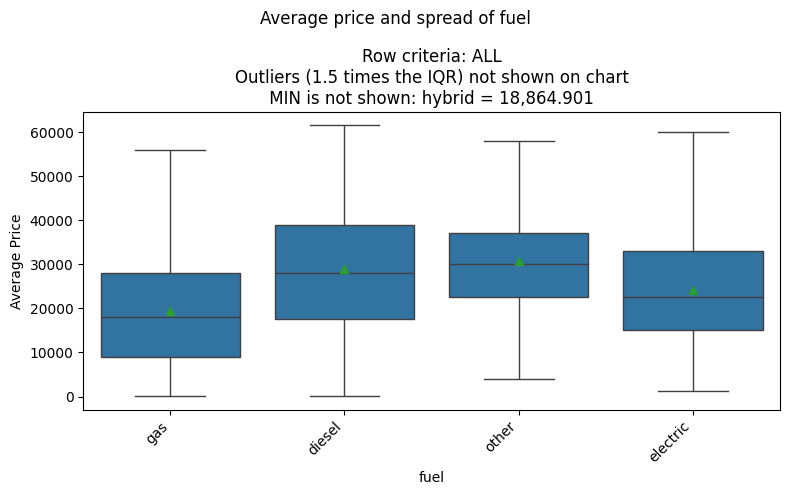

drop_outlier(): lower bound = 5118.748064267815
drop_outlier(): upper bound = 43242.62481321127
Potential outliers for fuel = 0
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

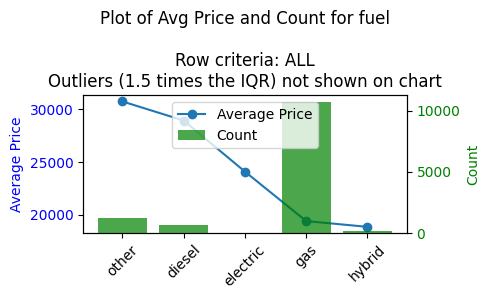

----
year has 81 distinct values
See 15 of them
      year    price  count
2   1930.0  $47,950      1
11  1949.0  $40,000      1
19  1960.0  $39,950      1
4   1933.0  $38,000      1
5   1936.0  $36,250      2
6   1940.0  $35,700      1
80  2021.0  $34,841     34
79  2020.0  $33,391    653
78  2019.0  $32,679   1126
3   1932.0  $29,500      1
77  2018.0  $28,987   1457
76  2017.0  $26,636   1344
17  1957.0  $25,000      1
9   1947.0  $25,000      1
8   1946.0  $25,000      1


<Figure size 640x480 with 0 Axes>

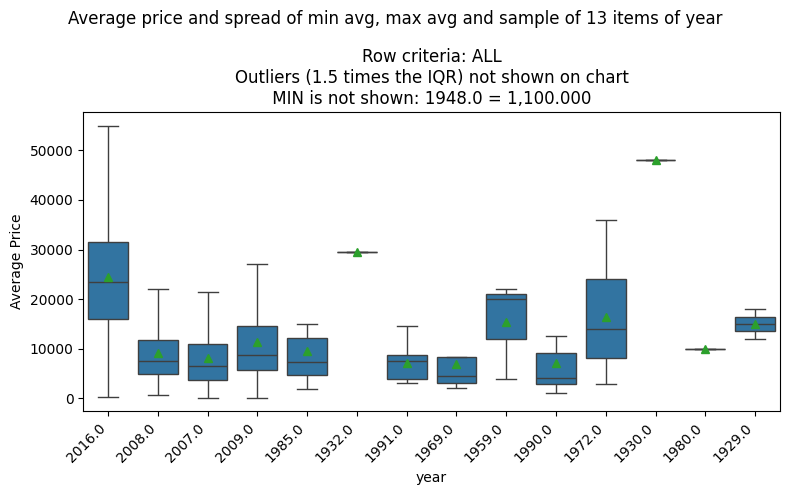

drop_outlier(): lower bound = -8842.12226117441
drop_outlier(): upper bound = 36270.30192813322
Potential outliers for year = 4
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

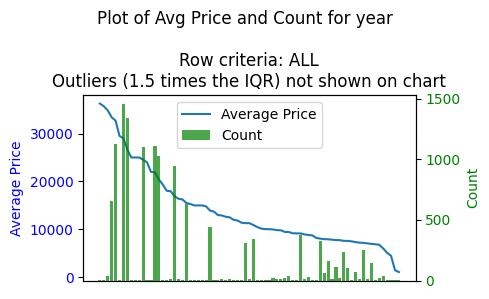

----


<Figure size 640x480 with 0 Axes>

In [31]:
col_list = ['fuel','year']

eval_col_avg_price(cars_clean_df, col_list, 
                    lower_price_q = 0.0, upper_price_q = 1, lower_count_q = 0.0, upper_count_q =1)

#### Let's drill down on data where avg price is high and count is also high
- Simplistically, these would seem to be valuable cars to the dealer
- This rule might help us understand data and get some intuition about features that drive revenue


In [32]:
print('interactive tool to use')
print('Uncomment to run if want to explore different quantiles')
col_list = ['region', 'manufacturer', 'model', 'fuel', 
            'title_status', 'transmission','type','paint_color','state','year']
# Choose lower_price_q (quantile lower bound for average price) 
# Choose lower_count_q (quantile lower bound for quantity sold) 
#eval_col_avg_price(cars_clean_df, col_list, 
#                    lower_price_q = 0.7, upper_price_q = 1, lower_count_q = 0.4, upper_count_q =1)

interactive tool to use
Uncomment to run if want to explore different quantiles


#### Recap of charts drilling down to top 30% in price and top 60% in volume
- Diesel fel and type pick-ups and trucks seem to sell in this high price-high volume range
- White and black color seem popular
- GMC, audi, and cadilac are more common manufacturers in this range
- States from middle and southern part of the USA have highest volume in this range



In [33]:
cars_clean_df['paint_color']

362637     black
362645     white
362646    custom
362649     white
362650     white
           ...  
385570     white
385571     black
385572      blue
385574     brown
385575     white
Name: paint_color, Length: 12804, dtype: object

#### Recap of outlier section
Prices outliers have been removed bsaed on IQR and how close price is to $0 (<$100 removed)

**The cleanest data set is called 'cars_clean_df' with 230,998 rows and 10 feature columns**

#### Data Split

- I need a hold our or test data set to test our final model
- I will use a k-fold cross-validation technique for hyperparamter tuning (cv=5)
- However, to also vary the feature set, we have an explicit valiation set of 10% also
- We will use 70% of data for training, 10% for feature validation, and cross-validatoin and 20% for final testing

In [34]:
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=42):
  # Split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Split the training set into train and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state)

  return X_train, X_val, X_test, y_train, y_val, y_test


In [35]:
X_df = cars_clean_df.drop(columns=['id','price'])
print(f"Feature columns are: {X_df.columns}")
y = cars_clean_df['price']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_df, y, test_size=0.2, val_size=0.1, random_state=42)


Feature columns are: Index(['region', 'manufacturer', 'model', 'fuel', 'title_status',
       'transmission', 'type', 'paint_color', 'state', 'odometer', 'year'],
      dtype='object')


#### Feature engineering and hyperparamter tuning

To improve our ability to predict car prices form the input data we will:
- Create useful columns from categorical columns (OneHotEncoding)
- Create standard scaled polynomial features for numerical columns

There are many, many other options but will focus on tools discussed to this point (Module 11) in the course

In [36]:
# Create one hot columns from the words in the model column.
# Use nltk to parse into lower case punctuation-free words without stop words.
# Also make sure the resulting list does not repeat values in the 'type' and 'manufacturer' columns.
# Use this list and resulting histogram count to create a large number of one_hot_columns in the main data frame,
# if a given wword has a count more than 50 in the given data frame (X_train usually)
# 
# Keep a separate list one_hot_cols of these columns to instruct the system's preproccessor transform to pass them through.
# Eventually could 


In [37]:
nltk.download('stopwords')
from nltk.corpus import stopwords

the_stop_words = stopwords.words('english')
def identify_model_keywords( X_df,  sample_size=1000000, src_col_name = 'model', stop_words = the_stop_words, min_occurrence=7000, verbose=False):
    #todo: 7000 min for testing - move to 50
    # custom feature for model column for now
    if stop_words is None:
        print("stop words invalid")
    col_to_clean = src_col_name
    act_sample_size = min(sample_size,X_df.shape[0])
    df = X_df[col_to_clean].reset_index().sample(act_sample_size).copy()
    #print(df.head())

    # Define stopwords list (includes 'the')
    stop_words = stop_words
    #print(f"the available df columns are: {X_df.columns}")
    type_words_set = set(X_df['type'])
    type_words = list(type_words_set)
    manufacturer_words_set = set(X_df['manufacturer'])
    manufacturer_words = list(manufacturer_words_set)
    
    # as we find one_hots that have low importance can add here to officially drop
    learned_low_value_words = []
    
    # Function to clean text and remove stopwords
    # Assumes inner function can see variables in outer scope
    def clean_text(text):    
      # Lowercase text
      text = text.lower()
      # Remove punctuation
      text = re.sub(r'[^\w\s]', '', text)
      # Tokenize words
      words = text.split()
      # Remove stopwords
      filtered_words1 = [word for word in words if word not in stop_words]
    
      filtered_words2 = [word for word in filtered_words1 if word not in type_words]
    
      filtered_words3 = [word for word in filtered_words2 if word not in manufacturer_words]
    
      filtered_words4 = [word for word in filtered_words3 if word not in learned_low_value_words]
    
      return filtered_words4
    
    
    # Apply cleaning function to 'text' column
    df['cleaned_text'] = df[col_to_clean].apply(clean_text)
    
    # Combine all cleaned text into a single list
    all_words = []
    for words in df['cleaned_text']:
      all_words.extend(words)
    
    # Create a dictionary to store word frequencies
    word_counts = {}
    for word in all_words:
      if word not in word_counts:
        word_counts[word] = 0
      word_counts[word] += 1
    
    # Filter out low-frequency words (optional)
    min_count = min_occurrence  # Adjust minimum count as needed
    
    filtered_counts = {word: count for word, count in word_counts.items() if count >= min_count}
    if verbose:
        print(f"word count is {len(filtered_counts)} using minimum occurrence level of {min_count}")
   
    return filtered_counts

#todo: get rid of this one after we get things working
def plot_model_keyword(filtered_counts_df):
    # Create a histogram
    plt.bar(filtered_counts_df.index, filtered_counts_df['word_count'])
    plt.xlabel("Word From Model feature")
    plt.ylabel("Frequency")
    plt.title("Histogram of Words (excluding stopwords, types, and manufacturers)")
    if filtered_counts_df.shape[0] > 30:
        plt.xticks([])
    else:
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        
    plt.show()
    plt.cla()
    plt.clf()

def get_expected_one_hot_cols(filtered_counts):
    return ['my_one_hot_' + word for word in filtered_counts.keys()]
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbfor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
class ModelofCarTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, column_names, stop_words, min_occurrence = 4000, max_one_hots = 3000, valid_words = []):
        self.column_names = column_names # it better be called 'model'!
        self.transformed_feature_names = []
        self.min_occurrence = min_occurrence
        self.max_one_hots = max_one_hots
        self.valid_words = valid_words # normally and recommended created by fit()
        # requires nltk only lightly for stopwords. could pickle?        
        self.stop_words = stop_words
        self.my_one_hot_prefix = 'my_one_hot_col_'
        self.already_fit = False
        
    def identify_model_keywords( self, X_df, min_occurrence = 7000, sample_size=1000000, src_col_name = 'model'):
        #print("in ModelofCarTransformer, calling identify_model_keywords()")
        return identify_model_keywords( X_df, sample_size, src_col_name, stop_words = self.stop_words,  min_occurrence = self.min_occurrence)
        
    # Create one_hot features from the model field
    def gen_model_one_hots( self, data, filtered_counts, valid_words):
    
        # Function for replacement
        def remove_special_chars(text):
            return re.sub(r'[^\w\s]', '', text)
    
        # Function to check if word exists (vectorized for efficiency)
        def check_for_word(text, word):
          # added lower case conversion
          return  text.str.lower().str.contains(word, case=False)
    
        df = data.copy()
        new_col_and_data = []
        new_col_list = []
        new_data_list = []
        count = 1
        df['model_w_o_special'] = 0
        sorted_filtered_words_list = sorted(filtered_counts.keys(), key=lambda x: x[0])
        for word_to_find in sorted_filtered_words_list:
            if count > self.max_one_hots:
                break
            if word_to_find in valid_words:
                #print(f'preparing {word_to_find} to be a one_hot_col')
                #new_col_array_bool = empty_array = np.empty(min(self.max_one_hots, df.shape[0]))
                #new_col_array_int = empty_array = np.empty(min(self.max_one_hots, df.shape[0]))
                new_col_array_bool = np.empty(df.shape[0])
                new_col_array_int = np.empty(df.shape[0])
                
                # Apply the function with vectorized operations
                
                df['model_w_o_special'] = df['model'].apply(remove_special_chars)        
                new_col_array_bool = check_for_word(df['model_w_o_special'], word_to_find)
            
                # Convert the boolean column to 0 or 1 (optional)
                new_col_array_int = new_col_array_bool.astype(int)
                
                # make sure you found some non-zero values
                condition = new_col_array_int == 1
                non_zeros = np.where(condition)    
                if len(non_zeros[0]) > 0:
                    # create a dictionoary of the column name and the associated array relevant to df
                    # todo: check for characters of word_to_find that can't be used as a column name
                    new_col_name = self.my_one_hot_prefix+ word_to_find
                    new_col_dict = {'new_col_name': new_col_name, 'new_col_one_hot': new_col_array_int}
                    new_col_and_data.append(new_col_dict)
                    new_col_list.append(new_col_name)
                    new_data_list.append(new_col_array_int)

                else:
                    #todo: raise exception here
                    print(f"************************************all zeros for : {word_to_find}")    
                    # for debug reasons
                    print(f"non_zeros : {non_zeros}")
                    print(f"new_col_array_int : {new_col_array_int}")
                    print(f"new_col_array_bool : {new_col_array_bool}")
            else:
                print(f"skipping {word_to_find}")

                       
        #print("in fit,gen_model, df rows = ", df.shape[0])
        if len(new_data_list)>0:
            #print("length of new_data_list", len(new_data_list))
            #print("df",np.shape(df))
            #print("df columns:", df.columns)
            # Stack arrays horizontally
            data_array = np.column_stack(new_data_list)
            #print("data_array",np.shape(data_array))
    
            df_merge_cols = [col for col in df.columns]
            for col in new_col_list:
                df_merge_cols.append(col)
                
            df_merged = pd.DataFrame(np.column_stack([df.to_numpy(), data_array]), columns=df_merge_cols)
            #print("df_final",np.shape(df_merged))
    
            df_final = df_merged.copy()
            #print("df_final",np.shape(df_final))
            #print("df_final cols", list(df_final.columns))
        else:
            df_final = df
        
        return df_final   
        
    def fit(self, X, y=None):
        if 'model' in X.columns:     
            X_df = pd.DataFrame(X)
            if self.already_fit:
                print("Already fit but refitting")
            #print("in ModelofCarTransformer.fit(), calling identify_model_keywords()")
            filtered_counts =self.identify_model_keywords(X_df)
            self.valid_words = filtered_counts.keys()
        else:
            self.valid_words = None

        return self 


    def rationalize_cols(self, X_w_some_one_hots):
        #print("In rationalize_cols()")
        new_zero_col_list = []
        for col in self.cols_after_fit:
            if not col in X_w_some_one_hots:
                if self.my_one_hot_prefix in col:                    
                    #print(f"adding {col} to rationalize shape to the original fit")
                    new_zero_col_list.append(col)
       
        if len(new_zero_col_list)>0:
            #print(f"shape to create zeros col array {X_w_some_one_hots.shape[0]} , {len(new_zero_col_list)} ")
            new_zero_col_array = np.zeros((X_w_some_one_hots.shape[0],len(new_zero_col_list)) )                
            X_w_some_one_hot_rationalized = X_w_some_one_hots.copy()            
            #print("length of new_data_list", len(new_zero_col_list))
            #print("X_w_some_one_hot_rationalized",np.shape(X_w_some_one_hot_rationalized))
            #print("X_w_some_one_hot_rationalized columns:", X_w_some_one_hot_rationalized.columns)
            #print("new_zero_col_array",np.shape(new_zero_col_array))
    
            df_merge_cols = [col for col in X_w_some_one_hot_rationalized.columns]
            for col in new_zero_col_list:
                df_merge_cols.append(col)
                
            df_merged = pd.DataFrame(np.column_stack([X_w_some_one_hot_rationalized.to_numpy(), new_zero_col_array]), columns=df_merge_cols)
            #print("df_final",np.shape(df_merged))
    
            df_final = df_merged.copy()            
            #print("df_final cols", list(df_final.columns))
        else:
            df_final = X_w_some_one_hots
        return df_final

    def transform(self, X):
        X_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        if 'model' in X.columns:
            #print("in ModelofCarTransformer,transform()")       
            X_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
            #print("in ModelofCarTransformer.transform(), calling identify_model_keywords()")        
            filtered_counts =self.identify_model_keywords(X_transformed)
            #todo: should raise or warn if valid_words is empty
            X_w_one_hots = self.gen_model_one_hots(X_transformed, filtered_counts, self.valid_words)
            X_w_one_hots = X_w_one_hots.drop(['model_w_o_special'], axis=1)
            
            for col in self.column_names:
                X_w_one_hots = X_w_one_hots.drop([col], axis=1)
                
        else:
            print("^^^^^^^^^^^^^^^^^^  NO MODEL COL ^^^^^^^^^^^^^^^^^^^^")
            X_transformed['model_inactive'] = 1
            X_w_one_hots = X_transformed[X_transformed['model_inactive']]

        self.transformed_feature_names = X_w_one_hots.columns
        if not self.already_fit:
            self.cols_after_fit = X_w_one_hots.columns
            self.already_fit = True
        else:
            # rationalize_columns creates any one_hot columns that were missing from above so that
            # column set of my_one_hots matches what was there at fit
            # Set them to zeros (because we know we didn't see any of these values in model field)
            X_w_one_hots = self.rationalize_cols(X_w_one_hots)
        
        #X_w_one_hots.to_csv("saved_output/last_transform.csv")
        #print(f"I was transformed: {self.transformed_feature_names} columns now")           
        print("in modelofcartransform, X_w_one_hots shape",np.shape(X_w_one_hots))
       
        return X_w_one_hots
        
    def get_feature_names_out(self, input_features):
        return self.transformed_feature_names


In [39]:

def set_up_one_hot_preprocessors(custom_model_cols, categorical_cols, numerical_cols, degrees=4, min_occurrence = 5000):

    my_model_of_car_transformer = ModelofCarTransformer(column_names=['model','manufacturer','type'], min_occurrence = min_occurrence, stop_words = the_stop_words)    
    #todo: target_col
    my_one_hot_preprocessor = make_column_transformer(
        (my_model_of_car_transformer, custom_model_cols),
        (Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degrees))                 
        ]), numerical_cols),        
        (OneHotEncoder(sparse_output=False,drop='first', handle_unknown='ignore'), categorical_cols),        
        remainder="drop" 
    )    

    return my_one_hot_preprocessor

def set_up_pipeline(preprocessor, alpha=None):
    if alpha is None:
        pipeline1 = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(Lasso(max_iter = 3000, alpha = 100))),
        ('regressor', Ridge(max_iter=1000))
        ])
    else:
        pipeline1 = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(Lasso(max_iter = 3000, alpha = 100))),
        ('regressor', Ridge(alpha=alpha, max_iter = 1000))
        ])
    return pipeline1



In [40]:
# Default global. Set by gridsearch to discovered value

def run_gridsearchcv(pipeline1, X_train,y_train, param_grid = {'regressor__alpha': [1]}):
    grid_search = GridSearchCV(pipeline1, param_grid, scoring='neg_mean_squared_error', verbose=2, cv=2)
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['regressor__alpha']
    print("best alpha",best_alpha)

    return grid_search, best_alpha

In [41]:
def prep_to_save_grid_search_details(grid_search, categorical_cols, numerical_cols, target_col, mse_train, mse_val):
    # Get the best model and its coefficients
    best_model = grid_search.best_estimator_
    best_lasso = best_model.named_steps['regressor']
    best_coef = best_lasso.coef_
    #print(best_coef)
    
    # Get feature names 
    feature_names_in = categorical_cols + numerical_cols
    feat_names_preprocessor = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    feat_names_selector = grid_search.best_estimator_.named_steps['selector'].get_feature_names_out()
    
    # Get the best score
    best_score = grid_search.best_score_
    print("Best score:", best_score)
    
    # get mse
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    print("mse:",mse)

    # Calculate RMSE
    rmse_train = np.sqrt(mse_train)
    print("RMSE train:", rmse_train)

    rmse_val = np.sqrt(mse_val)
    print("RMSE val:", rmse_val)
    
    alpha = grid_search.best_params_['regressor__alpha']
    print("alpha:", alpha)
    # Set global BEST_ALPHA
    BEST_ALPHA = alpha

    details = {'alpha':alpha, 'best_score': best_score,'best_model': best_model, \
               'feature_names_in': feature_names_in, \
               'feat_names_preprocessor': feat_names_preprocessor, 'feat_names_selector': feat_names_selector, \
               'mse_train': mse_train, 'mse_val': mse_val, \
               'rmse_train': rmse_train, 'rmse_val': rmse_val}
    return details
    

In [42]:
def run_pipe_and_predict(pipeline2, X_train, y_train, X_val, y_val, verbose=True):
    if verbose:
        print("Running fit")
    pipeline2.fit(X_train, y_train)
    if verbose:
        print("running predict for X_train")
    train_pred = pipeline2.predict(X_train)
    if verbose:
        print("running predict for X_val")    
    val_pred = pipeline2.predict(X_val)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_val = mean_squared_error(y_val, val_pred)
    if verbose:
        print(f"model predict rmse_train: {np.sqrt(mse_train):,f}")
        print(f"model predict rmse_val: {np.sqrt(mse_val):,f}")
        print(f"model predict rmse gap :{abs(np.sqrt(mse_train)-np.sqrt(mse_val)):,f}")

    
    return mse_train, mse_val

In [43]:
def run_grid_search_experiment(categorical_cols, numerical_cols, target_col, X_train, y_train, X_val, y_val, exp_id="default", dump_to_pickle=False, min_occurrence = 5000):
    try:
        details = None
        best_alpha = None
        set_config(transform_output="default")
        start_time = time.time()
        time_struct = time.localtime(start_time)
        formatted_time = time.strftime("%I:%M:%S", time_struct)
        print(f'Starting experiment {exp_id} at {formatted_time}')        
        details_list = []
        
        model_cols = ['manufacturer', 'type', 'model']

        preprocessor = set_up_one_hot_preprocessors(model_cols, categorical_cols, numerical_cols, min_occurrence = min_occurrence)

        pipeline1 = set_up_pipeline(preprocessor)

        param_grid = {'regressor__alpha': [ 1e4, 1, 1e2, 1e-2, 1e-1]}    
        grid_search, best_alpha = run_gridsearchcv(pipeline1, X_train,y_train, param_grid)

        if best_alpha is None:
            best_alpha = 1
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Grid Search done. Elapsed_time: {elapsed_time}")
        pipeline2 = set_up_pipeline(preprocessor, best_alpha)               
        
        mse_train, mse_val = run_pipe_and_predict(pipeline2, X_train, y_train, X_val, y_val)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Pipe and Predict done. Elapsed_time: {elapsed_time}")
        print("train ",mse_train, " val", mse_val)
        details = prep_to_save_grid_search_details(grid_search, categorical_cols, numerical_cols, target_col, mse_train, mse_val)
        
        details_list.append(details)
        
        if dump_to_pickle:
            with open(f"saved_output/{exp_id}_details.pickle", "wb") as f:
              # Pickle the list and write it to the file
              pickle.dump(details, f)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"finished experiment elapsed_time: {elapsed_time}")        
    finally:
        set_config(transform_output="default")

    return details

    
               
                    

In [44]:
print(cars_clean_df.columns)
print(X_train.shape)
print(X_test.shape)

Index(['region', 'manufacturer', 'model', 'fuel', 'title_status',
       'transmission', 'type', 'paint_color', 'state', 'odometer', 'year',
       'id', 'price'],
      dtype='object')
(8962, 11)
(2561, 11)


#### We created a dynamic one-hot encoding based on phrase in the model field
- The above process uses them but if you want to see examples of popular words used to encode, use this cell below


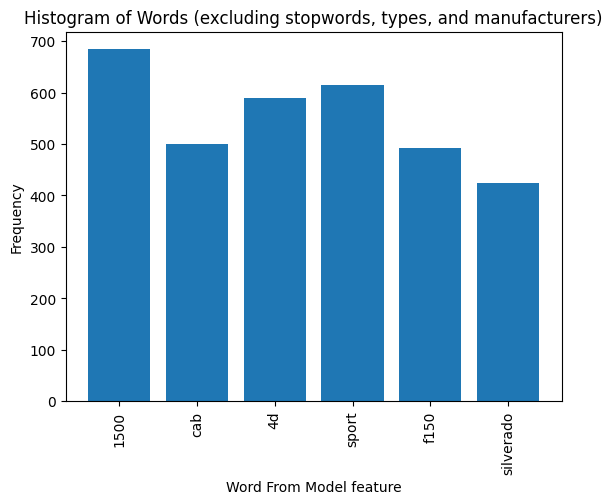

number of one hots to be created for model 6


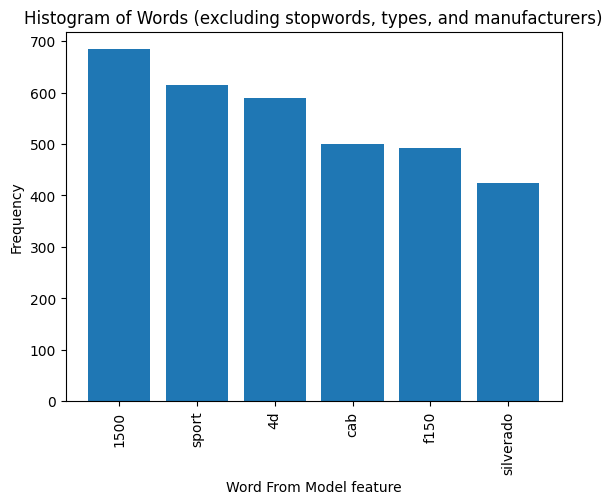

<Figure size 640x480 with 0 Axes>

In [45]:
# Set min_occurrence to different values to see the distribution of popular words in the model field
# % of rows in X_train
pct_tuning_min_occurrence = 4
tuning_min_occurrence = round(pct_tuning_min_occurrence/100*X_train.shape[0]) # 
filtered_counts =identify_model_keywords(X_train, min_occurrence = tuning_min_occurrence)
filtered_counts_df = pd.DataFrame.from_dict(filtered_counts, orient='index', columns=['word_count'])
plot_model_keyword(filtered_counts_df)
print("number of one hots to be created for model", filtered_counts_df.shape[0])
df_sorted = filtered_counts_df.sort_values(by='word_count', ascending=False)
top_values_df = df_sorted.iloc[:15]
plot_model_keyword(top_values_df)

### THIS CODE WILL TAKE MANY MINUTES TO RUN. 
### SET OK_TO_RUN_TUNING = True, if you want to run it


In [46]:
if OK_TO_RUN_TUNING:
    #categorical_cols = ['region', 'manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']

    #categorical_cols =  ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', \
    #                                                  'type', 'paint_color', 'state']
    
    #categorical_cols =  [ 'manufacturer', 'model', 'fuel', 'title_status', 'transmission',  \
    #                                                  'type', 'paint_color', 'state']
    
    #categorical_cols = ['state', 'type', 'manufacturer','paint_color','fuel', 'title_status', 'condition', 'cylinders']
    #categorical_cols = [ 'type']
    #categorical_cols = ['state', 'type', 'manufacturer','paint_color','fuel', 'title_status', 'condition', 'cylinders']
    #categorical_cols = ['state', 'type', 'manufacturer','paint_color','fuel', 'title_status', 'condition', 'cylinders']
    #categorical_cols = ['type', 'state', 'manufacturer', 'fuel','title_status', 'transmission', 'paint_color']
    categorical_cols = ['type', 'state', 'manufacturer', 'fuel','title_status', 'transmission', 'paint_color','region']
    
    
    numerical_cols = ['year']
    #numerical_cols = ['year']
    #numerical_cols = []
    target_col = 'price'
    details = run_grid_search_experiment(categorical_cols, numerical_cols, target_col, X_train, y_train, X_val, y_val, exp_id = 1, min_occurrence =tuning_min_occurrence)



Starting experiment 1 at 04:29:05
Fitting 2 folds for each of 5 candidates, totalling 10 fits
in modelofcartransform, X_w_one_hots shape (4481, 0)
in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ...........................regressor__alpha=10000.0; total time=   0.7s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ...........................regressor__alpha=10000.0; total time=   0.7s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END .................................regressor__alpha=1; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END .................................regressor__alpha=1; total time=   0.7s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END .............................regressor__alpha=100.0; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END .............................regressor__alpha=100.0; total time=   0.7s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ..............................regressor__alpha=0.01; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ..............................regressor__alpha=0.01; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ...............................regressor__alpha=0.1; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (4481, 0)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


in modelofcartransform, X_w_one_hots shape (4481, 0)
[CV] END ...............................regressor__alpha=0.1; total time=   0.6s
in modelofcartransform, X_w_one_hots shape (8962, 6)


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


best alpha 1
Grid Search done. Elapsed_time: 9.044450759887695
Running fit
in modelofcartransform, X_w_one_hots shape (8962, 6)
running predict for X_train
in modelofcartransform, X_w_one_hots shape (8962, 6)
running predict for X_val
in modelofcartransform, X_w_one_hots shape (1281, 6)
model predict rmse_train: 7,599.530682
model predict rmse_val: 7,604.390183
model predict rmse gap :4.859502
Pipe and Predict done. Elapsed_time: 10.787217140197754
train  57752866.58206887  val 57826750.06222156
Best score: -58264058.65444382
in modelofcartransform, X_w_one_hots shape (1281, 6)
mse: 57826750.06222156
RMSE train: 7599.530681697974
RMSE val: 7604.390183454658
alpha: 1
finished experiment elapsed_time: 10.801217794418335


C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\bbfor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [47]:
#details




### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Feature Selection

I will let the lasso regularization decide the feature selection through linear regression coefficients
- I will use the GridSearchCV to find the optimal lasso regression hyperparameter

To improve our ability to predict car prices form the input data we will generate 3 types of features: polynomial, interaction (x1*x2) and exponential. 

There are many, many other options but will focus on tools discussed to this point (Module 11) in the course





- 

In [48]:
# feat import after encoding
def get_importance_by_partial_match(feat_map, search_string):
    print(feat_map)
    matching_keys = [key for key in feat_map.keys() if search_string in key]
    feat_impt = 0
    for a_match in matching_keys:
        feat_impt = feat_impt + feat_map[a_match]
        
    return feat_impt
    
def run_feat_importance_perm(X_train, y_train, X_val, y_val, feat_cols, preprocessor, alpha, verbose=False):


    X_train_cols = X_train[feat_cols]
    X_val_cols = X_val[feat_cols]

    if verbose:
        print('X_train passed in cols',X_train.columns)
        print('X_train feature cols',X_train_cols.columns)
    pipeline = set_up_pipeline(preprocessor, alpha = alpha)
    
    #pipeline.fit(X_train_cols, y_train)
    pipeline.fit(X_train, y_train)
    
    


    if verbose:
        print("original feature names")
        print(feat_cols)
        print("---")
        print(f"Number original features is {len(X_train.columns)}")

    preprocessor_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selector_feature_names = pipeline.named_steps['selector'].get_feature_names_out()   
    
    if verbose:
        print(f"Number features in preprocessor step (feature engineering) is {len(preprocessor_feature_names)}")
        print("Number of features sent to model after feature selection is ", len(selector_feature_names))    
        print("---")    

        print("Run with all features to get MSE and RMSE")
    mse_train, mse_val = run_pipe_and_predict(pipeline, X_train_cols, y_train, X_val_cols, y_val)    
    if verbose: 
        print(f"MSE train: {mse_train:,.0f}")
        print(f"MSE val: {mse_val:,.0f}")

    print("----")
    print("Calculating permutations to find feature importance per feature")          
    # Calculate permutation importance using the pipeline 
    feat_import_results = permutation_importance(estimator=pipeline, X=X_val_cols, y=y_val, scoring="neg_mean_squared_error", n_repeats=10, n_jobs=-1)


    return feat_import_results, pipeline, mse_train, mse_val
    


In [49]:
def prep_to_save_feat_import_details(feat_import_results, pipeline, feat_cols, target_col, mse_train, mse_val, alpha, min_occurrence, verbose=False):
    

    print("Feature columns with mean - 2*std GREATER THAN  0")    
    for i in feat_import_results.importances_mean.argsort()[::-1]:
        if feat_import_results.importances_mean[i] - 2 * feat_import_results.importances_std[i] > 0:
            print(f"{feat_cols[i]:<40}"
                  f"{feat_import_results.importances_mean[i]:,.0f}"
                  f" +/- {feat_import_results.importances_std[i]:,.0f}")
    print("----")    
    if verbose:        
        print("Feature columns with mean - 2*std LESS THAN OR EQUAL TO 0")
        for i in feat_import_results.importances_mean.argsort()[::-1]:
            if feat_import_results.importances_mean[i] - 2 * feat_import_results.importances_std[i] <= 0:
                print(f"{feat_cols[i]:<40}"
                      f"{feat_import_results.importances_mean[i]:,.0f}"
                      f" +/- {feat_import_results.importances_std[i]:,.0f}")

    # capture the change in rmse of the model field
    for i in feat_import_results.importances_mean.argsort()[::-1]:          
        if feat_cols[i] == 'model':
            if math.isnan(feat_import_results.importances_mean[i]):
                mean = 0
            else:
                mean = feat_import_results.importances_mean[i]
                
            if math.isnan(feat_import_results.importances_std[i]):
                std = 0
            else:
                std = feat_import_results.importances_std[i]
                
            mean_change_rmse_for_model_field = np.sqrt(abs(mean))
            std_change_rmse_for_model_field = np.sqrt(abs(std))

    
    importance_map = dict(zip(feat_cols, feat_import_results.importances_mean))
    if verbose:
        print("Full list of feature columns")    
        for orig_feat in feat_cols:
            orig_impt = importance_map[orig_feat]
            print(f"Original Feature: {orig_feat}, Average Importance (MSE change): {orig_impt:,.0f}")    

        # Get feature names 
       
    preprocessor_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selector_feature_names = pipeline.named_steps['selector'].get_feature_names_out()        
    
   
    # Calculate RMSE
    rmse_train = np.sqrt(mse_train)
    print("RMSE train:", rmse_train)

    rmse_val = np.sqrt(mse_val)
    print("RMSE val:", rmse_val)
    

    details = {'alpha':alpha, 'min_occurrence': min_occurrence, 
            'feature_names_in': feat_cols, 
            'preprocessor_feature_names': preprocessor_feature_names, 'selector_feature_names': selector_feature_names, 
            'mse_train': mse_train, 'mse_val': mse_val, 
            'rmse_train': rmse_train, 'rmse_val': rmse_val, 
            'orig_feat_importance_map': importance_map, 
            'raw_feat_importance_mean' : feat_import_results.importances_mean, 
            'raw_feat_importance_std' : feat_import_results.importances_std,
            'mean_change_rmse_for_model_field' : mean_change_rmse_for_model_field,
            'std_change_rmse_for_model_field' : std_change_rmse_for_model_field               
            }
    return details


In [50]:
def run_feat_import_experiment(categorical_cols, numerical_cols, target_col, X_train, 
                               y_train, X_val, y_val, alpha, min_occurrence = None, xp_id="default", dump_to_pickle=False, verbose=False):
    start_time = time.time() 
    time_struct = time.localtime(start_time)
    formatted_time = time.strftime("%I:%M:%S", time_struct)
    print(f'Starting experiment {xp_id} at {formatted_time}')
    if verbose:        
        print("rows in training data",X_train.shape[0])
        print("rows in validation data",X_val.shape[0])

    model_cols = ['manufacturer','model', 'type']
    if verbose: 
        print(min_occurrence)
    if min_occurrence is not None:
        preprocessor = set_up_one_hot_preprocessors(model_cols, categorical_cols, numerical_cols, min_occurrence = min_occurrence)
    else:
        preprocessor = set_up_one_hot_preprocessors(model_cols, categorical_cols, numerical_cols)
    
    feat_cols = categorical_cols + numerical_cols
    for col in model_cols:
        if col not in feat_cols:
            feat_cols.append(col)
    
    feat_import_results, pipeline, mse_train, mse_val = run_feat_importance_perm(X_train, y_train, X_val, y_val, feat_cols, preprocessor, alpha)

    details = prep_to_save_feat_import_details(feat_import_results, pipeline, feat_cols, target_col, mse_train, mse_val, alpha, min_occurrence)

    if dump_to_pickle:
        with open(f"saved_output/{xp_id}_feat_import_details.pickle", "wb") as f:
          # Pickle the list and write it to the file
          pickle.dump(details, f)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"finished experiment {xp_id} in elapsed_time: {elapsed_time}")        
    return details


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### This code may run for many tens of minutes or more depending on data size.
- Set OK_TO_RUN_FEAT_IMPORT = True, if you want to run it


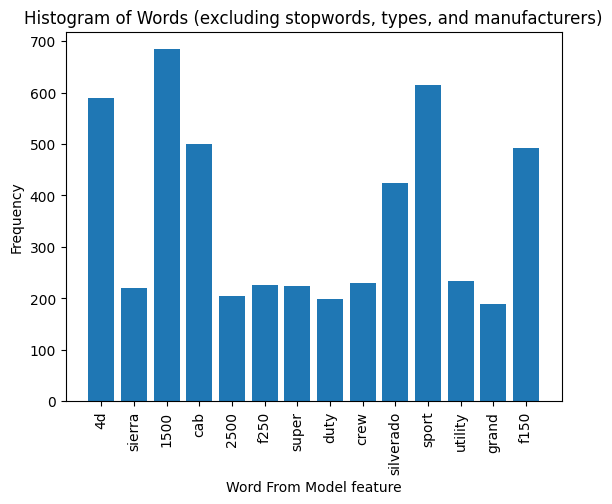

number of one hots to be created for model 14


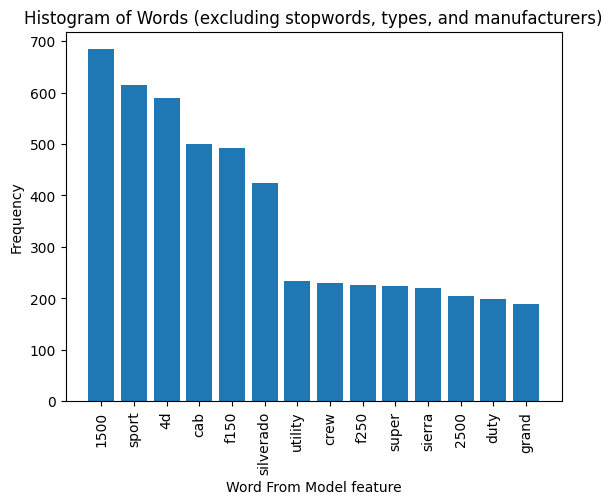

<Figure size 640x480 with 0 Axes>

In [51]:
# Set min_occurrence to different values to see the distribution of popular words in the model field
# % of rows in X_train
pct_feat_import_min_occurrence = 2
feat_import_min_occurrence = round(pct_feat_import_min_occurrence/100*X_train.shape[0]) # 
filtered_counts =identify_model_keywords(X_train, min_occurrence = feat_import_min_occurrence)
filtered_counts_df = pd.DataFrame.from_dict(filtered_counts, orient='index', columns=['word_count'])
plot_model_keyword(filtered_counts_df)
print("number of one hots to be created for model", filtered_counts_df.shape[0])
df_sorted = filtered_counts_df.sort_values(by='word_count', ascending=False)
top_values_df = df_sorted.iloc[:15]
plot_model_keyword(top_values_df)

In [52]:
if OK_TO_RUN_FEAT_IMPORT:
    categorical_cols = ['type', 'state', 'manufacturer', 'fuel','title_status', 'transmission', 'paint_color','region']
    #one_hot_cols  = [col for col in df2.columns if col.startswith('my_one')]
    numerical_cols = ['year']
    target_col = 'price'
    alpha = BEST_ALPHA
    feat_import_details = run_feat_import_experiment(categorical_cols, numerical_cols, target_col,\
                                                     X_train, y_train, X_test, y_test, alpha, min_occurrence = feat_import_min_occurrence, dump_to_pickle=False)


#### This code may run for more than an hour depending on data size.
- Set OK_TO_RUN_FEAT_IMPORT_ADDITIONAL = True, if you want to run it


In [53]:
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    # run for several alpha values and chart rmse
    alphas = [1e-2,1e-1,1,BEST_ALPHA, 1e1,1e2,1e3]
    alphas = list(set(alphas))
    alphas.sort()
    exp_alphas = []
    for alpha in alphas:
        xp_id = "exp_alpha_"+f"{alpha}"   
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print(f"Running experiment {xp_id} for alpha: {alpha:,.4f}")
        feat_import_details = run_feat_import_experiment(categorical_cols, numerical_cols, target_col,                                                     
                                                     X_train, y_train, X_test, y_test, alpha, xp_id = xp_id, min_occurrence = 30, dump_to_pickle=False)
        rmse_train = feat_import_details['rmse_train']
        rmse_val = feat_import_details['rmse_val']
        exp_dict = {'alpha':alpha, 'rmse_train':rmse_train, 'rmse_val':rmse_val}
        exp_alphas.append(exp_dict)
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print('')


In [55]:
def overfit_plot_check(df, x, y_train,y_test, xlabel, ylabel, xlog=False):
        
    # Create the lineplot
    sns.lineplot(df,x=x,y=y_train, label='Train Error', marker='o')
    sns.lineplot(df, x=x, y=y_test, label='Test Error', marker='o')

    # Customize plot (optional)
    plt.legend()  # Add a legend
    if xlog:
        xlabel = xlabel + '(log scale)'
        plt.xscale('log')
    
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Check for overfitting. RMSE vs Alpha hyperparameter values')        
    # Show the plot
    plt.show()
    plt.cla()
    plt.clf()
    

In [56]:
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    df = pd.DataFrame(exp_alphas)
    overfit_plot_check(df, 'alpha', 'rmse_train', 'rmse_val', 'Alpha', 'RMSE', xlog=True)

In [57]:
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    # minimumn occurrence settings as a function of the percent size of the X_train data frame
    min_occurrences = [max(2, round((i/100)*X_train.shape[0]))for i in [0.05,0.5,1,2,3,5,10,25,50]]
    min_occurrences = list(set(min_occurrences))
    
    print(min_occurrences)                   

In [58]:
# run for several min_occurence values and chart rmse
min_occurrences = [max(2, round((i/100)*X_train.shape[0]))for i in [0.25,0.5,1,2,3,5,10,25]]
min_occurrences = list(set(min_occurrences))
print(f"Running experiments for this range of minimum occurrences: {min_occurrences} ")                  
exp_min_o = []
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    for min_occurrence in min_occurrences:
        xp_id = "exp_min_occurrence_"+f"{min_occurrence}"   
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print(f"Running experiment {xp_id} for min_occurrence: {min_occurrence:,.4f}")
        feat_import_details = run_feat_import_experiment(categorical_cols, numerical_cols, target_col,                                                     
                                                     X_train, y_train, X_test, y_test,BEST_ALPHA, xp_id = xp_id, min_occurrence = min_occurrence, dump_to_pickle=False)
        rmse_train = feat_import_details['rmse_train']
        rmse_val = feat_import_details['rmse_val']
        mean_change_rmse_for_model_field = feat_import_details['mean_change_rmse_for_model_field']
        std_change_rmse_for_model_field = feat_import_details['std_change_rmse_for_model_field']
       
        exp_dict = {'min_occurrence':min_occurrence, 'rmse_train':rmse_train, 'rmse_val':rmse_val,
                    'mean_change_rmse_for_model_field':mean_change_rmse_for_model_field,
                    'std_change_rmse_for_model_field':std_change_rmse_for_model_field
                    }
        exp_min_o.append(exp_dict)
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print('')


Running experiments for this range of minimum occurrences: [448, 896, 2240, 269, 45, 179, 22, 90] 


In [59]:
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    df = pd.DataFrame(exp_min_o)
    overfit_plot_check(df, 'min_occurrence', 'rmse_train', 'rmse_val', 'Minimum Occurrence of Work in Model Field', 'RMSE', xlog=False)

In [60]:
def feat_import_check_plot_w_std(x, y_mean, y_err, xlabel, ylabel, xlog=False):

    # Create the error bar plot
    plt.errorbar(x, y_mean, yerr=y_err, fmt='o-', capsize=5)    
    
    # Add labels and title
    plt.title(f'Mean Plot with Standard Deviation for {xlabel}')
    
    # Customize plot (optional)
    if xlog:
        xlabel = xlabel + '(log scale)'
        plt.xscale('log')
    
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Adjust styles as needed

    # Show the plot
    plt.show()
    plt.cla()
    plt.clf()


In [61]:
if OK_TO_RUN_FEAT_IMPORT_ADDITIONAL:
    df.fillna(0, inplace=True)
    df = df.sort_values(by='min_occurrence', ascending=True)
    feat_import_check_plot_w_std(df['min_occurrence'], df['mean_change_rmse_for_model_field'], df['std_change_rmse_for_model_field'], 'Minimum Occurrence of Work in Model Field', 'Change in RMMSE for Model Field', xlog=True)
    df_non_zero = df[df['mean_change_rmse_for_model_field'] != 0]
    feat_import_check_plot_w_std(df_non_zero['min_occurrence'], df_non_zero['mean_change_rmse_for_model_field'], df_non_zero['std_change_rmse_for_model_field'], 'Minimum Occurrence of Work in Model Field (Non-Zero Only) ', 'Change in RMMSE for Model Field', xlog=False)

type has 3 distinct values
See 3 of them
     type    price  count
8  pickup  $31,116   3293
7   other  $25,147   1233
3   coupe  $22,963   1102
Will display all categories:
['pickup', 'other']


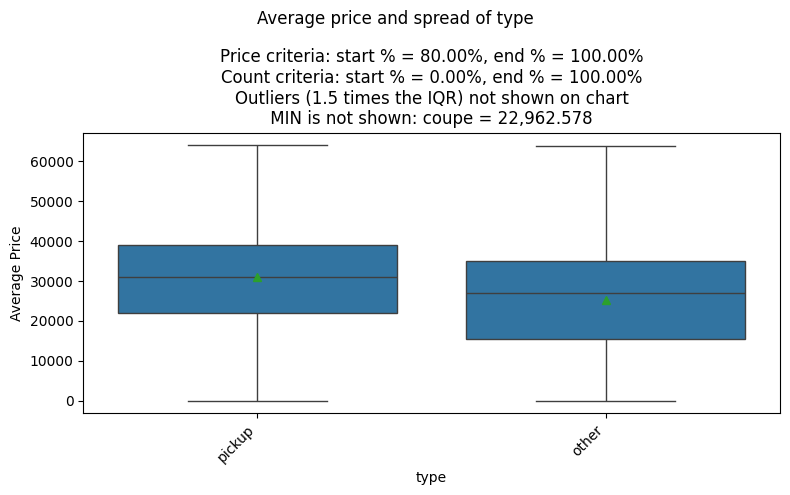

drop_outlier(): lower bound = 17939.957438779922
drop_outlier(): upper bound = 34245.902482520614
Potential outliers for type = 0
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

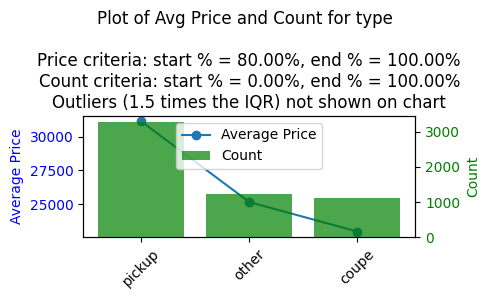

----


<Figure size 640x480 with 0 Axes>

In [63]:
col_list = ['type']
eval_col_avg_price(car_df, col_list, 
                    lower_price_q = 0.8, upper_price_q = 1, lower_count_q = 0.0, upper_count_q =1)

manufacturer has 4 distinct values
See 4 of them
   manufacturer    price  count
10      ferrari  $49,450      2
30      porsche  $36,237     80
35        tesla  $33,722     39
32        rover  $32,976    123
Will display all categories:
['ferrari', 'porsche', 'tesla']


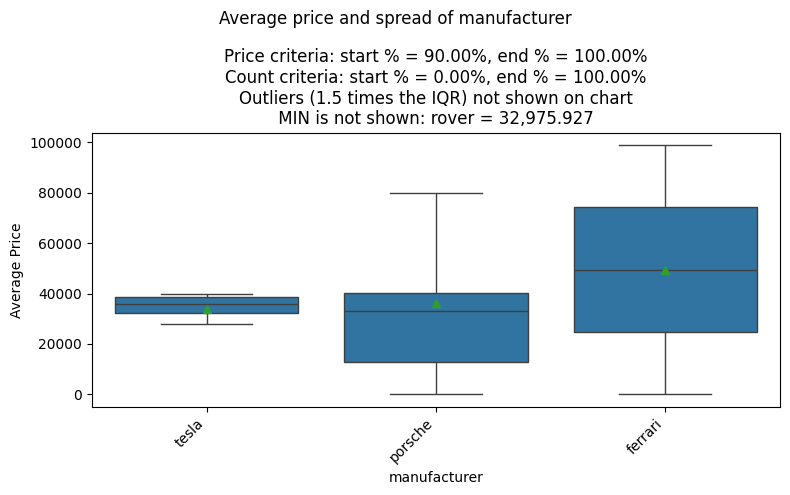

drop_outlier(): lower bound = 24527.66424425421
drop_outlier(): upper bound = 48547.53645344748
Potential outliers for manufacturer = 1
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

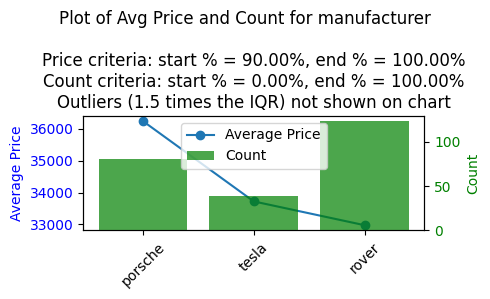

----


<Figure size 640x480 with 0 Axes>

In [65]:
col_list = ['manufacturer']
eval_col_avg_price(car_df, col_list, 
                    lower_price_q = 0.9, upper_price_q = 1, lower_count_q = 0.0, upper_count_q =1)

fuel has 3 distinct values
See 3 of them
       fuel    price  count
4     other  $34,044   2184
0    diesel  $33,144   2257
1  electric  $22,994     75
Will display all categories:
['other', 'diesel']


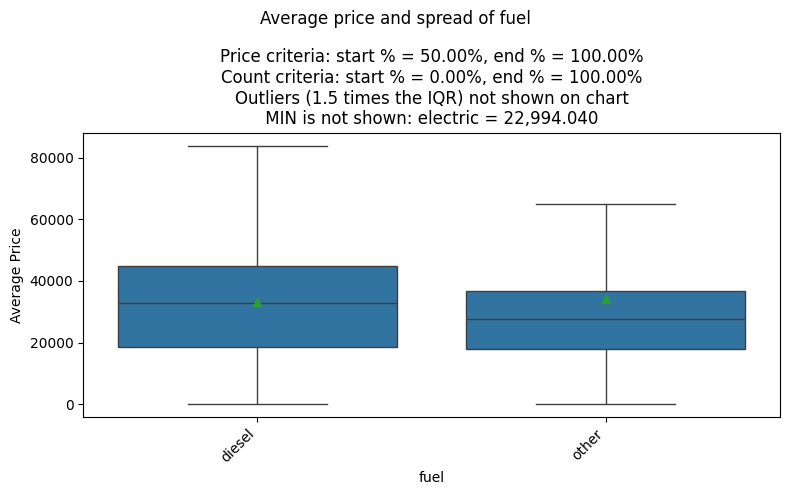

drop_outlier(): lower bound = 19781.621996097616
drop_outlier(): upper bound = 41880.93943199504
Potential outliers for fuel = 0
Processing Avg Price and Count Chart - May take up to 30 seconds for some charts
no duplicates


<Figure size 640x480 with 0 Axes>

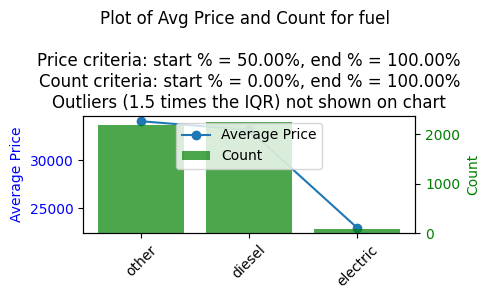

----


<Figure size 640x480 with 0 Axes>

In [67]:
col_list = ['fuel']
eval_col_avg_price(car_df, col_list, 
                    lower_price_q = 0.5, upper_price_q = 1, lower_count_q = 0.0, upper_count_q =1)